<a href="https://colab.research.google.com/github/stephenkiilu/NLP_Week2/blob/main/Stephen_Kiilu_day3_lab_decoding_strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Decoding Algorithms in Natural Language Processing




# Review:


## Language modeling:

* Setup:
  * $Y = (y_1,y_2,\dots,y_T)$, where $y_t \in \mathcal{V}$ with $\mathcal{V}$ a set of all unique tokens.
  * The sequence length $T \in \{1,2,3,\dots\}$ may vary from one sequence to another.
  * $\mathcal{V}$ includes a special symbol $\langle eos \rangle$ as well as a few other ones such as $\langle bos \rangle$, $\langle unk \rangle$, etc.
  * $y_T = \langle eos \rangle$ for any $Y$.

* Goal:
  * Build a model (parametrized by $\theta$) that computes a probability $p_\theta (Y)$.
  * A reasonable $Y$ receives a high probability (according to our training distribution).

`GPT-2` demo the lab session in day 1 was a perfect example of this (although we used it in a conditional language model in a sentence completion task).

## Conditional language modeling:

$$
\hat{Y} = \underset{Y\in\mathcal{Y}}{\arg\max} \log p_\theta (Y\mid X),\quad \text{where}
$$
* $X$ is the context (source sentence in machine translation).
* $\hat{Y}$ is the target sentence that our model generates.

We explored this in depth in the context of machine translation in day 2.

# Contents:
## Review of materials from day 1 & 2 (10 mins)
## Part 1: Decoding Algorithm Fundamentals (1 hour)
1. Greedy decoding
2. Beam search
3. Ancestral sampling
4. Top-$k$ sampling
5. Necleus (top-$p$) sampling

## Intermission (10 minutes)

## Part 2: Curses of Approximate Decoding Algorithms (30 minutes)
* Infinitely long sequences
* Premature sequences
* Hallucination

## Q&A Session (10 minutes)

In [1]:
! git clone https://github.com/pytorch/fairseq.git &> /dev/null; cd fairseq; pip install . &> /dev/null; # fairseq setup
! pip install sacremoses subword_nmt fastBPE sentencepiece bitarray &> /dev/null # tokenziers setup

In [2]:
# imports
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import operator, math, pickle, os
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# downloading LSTM LM trained on wikitext-2 -- for decoding code walkthrough

! gdown https://drive.google.com/uc?id=1OKPu0moBvDqW1R52Az2CVAE1dYtXqixK # model
! gdown https://drive.google.com/uc?id=1QkgivpD2cjHxZxg6diIgLaOpMbp4Kh7A # model args.
! gdown https://drive.google.com/uc?id=1qsAAFVMjyp-HWno4WEy5S9EdxsK5VLj_ # vocab.
! gdown https://drive.google.com/uc?id=1UG4h0HEMaWaloKLcC1zxMCpDR1e7RoES # utils


# downloading the standard transformer model trained w/ IWSLT’17 FR-EN. -- for decoding demo

! gdown https://drive.google.com/uc?id=1HNlwzSU8N3eX4vAxk36rmWZiBXYJDnsS # model (iwslt17fren.pt)
! gdown https://drive.google.com/uc?id=1XjoLni70BHSsFpo7snls1fjANVdxWj5x # dict.fr.txt
! gdown https://drive.google.com/uc?id=1iNG7yVwHbVLEwFneeon9udwL5hAMwCz7 # dict.en.txt
! gdown https://drive.google.com/uc?id=1NbZyYDEcRAwTw0JVPxm7yjiyOR5Nkqgv # sentencepiece.bpe.model
! gdown https://drive.google.com/uc?id=1WexFfEGS5fWRXEdtD0pn6h4GegtiWnhn # sentencepiece.bpe.vocab

! mkdir /content/iwslt-data/
! mv /content/dict.en.txt /content/iwslt-data/
! mv /content/dict.fr.txt /content/iwslt-data/
! mv /content/sentencepiece.bpe.model /content/iwslt-data/
! mv /content/sentencepiece.bpe.vocab /content/iwslt-data/

Downloading...
From: https://drive.google.com/uc?id=1OKPu0moBvDqW1R52Az2CVAE1dYtXqixK
To: /content/model_best.pt
100% 84.9M/84.9M [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QkgivpD2cjHxZxg6diIgLaOpMbp4Kh7A
To: /content/model_best_args.pkl
100% 1.23k/1.23k [00:00<00:00, 2.11MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qsAAFVMjyp-HWno4WEy5S9EdxsK5VLj_
To: /content/model_best_vocab.pkl
100% 831k/831k [00:00<00:00, 96.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UG4h0HEMaWaloKLcC1zxMCpDR1e7RoES
To: /content/utils.py
100% 27.6k/27.6k [00:00<00:00, 30.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HNlwzSU8N3eX4vAxk36rmWZiBXYJDnsS
To: /content/iwslt17fren.pt
100% 663M/663M [00:04<00:00, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XjoLni70BHSsFpo7snls1fjANVdxWj5x
To: /content/dict.fr.txt
100% 76.2k/76.2k [00:00<00:00, 75.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iNG7yVwHbVLEwFneeon9ud

In [4]:
# model for decoding method walkthrough.
class RNNLanguageModel(nn.Module):
    def __init__(self, options):
        super().__init__()
        self.eos_idx = options["eos_idx"]
        self.drop = nn.Dropout(options["dropout"])
        self.lookup = nn.Embedding(
            num_embeddings=options["num_embeddings"],
            embedding_dim=options["embedding_dim"],
            padding_idx=options["padding_idx"],
        )
        self.rnn = eval(options["rnn_type"])(
            options["input_size"],
            options["hidden_size"],
            options["num_layers"],
            dropout=options["dropout"],
            batch_first=True,
        )
        self.projection = nn.Linear(options["hidden_size"], options["output_dim"])
        if options["tie_weights"]:
            self.projection.weight = self.lookup.weight

    def forward(self, encoded_input_sequence):
        logits, _ = self.step(encoded_input_sequence, None)
        return logits

    def step(self, encoded_input_sequence, hidden):
        embeddings = self.drop(self.lookup(encoded_input_sequence))
        output, hidden = self.rnn(embeddings, hidden)
        output = self.drop(output)
        logits = self.projection(output)
        return logits, hidden

ckpt = torch.load("/content/model_best.pt",map_location=torch.device(device))
model_args = pickle.load(open("/content/model_best_args.pkl", "rb"))
vocab = pickle.load(open("/content/model_best_vocab.pkl", "rb"))

options = {**model_args.__dict__}
options["padding_idx"] = vocab.get_id('<pad>')
options["eos_idx"] = vocab.get_id('<eos>')
options["num_embeddings"] = options['dataset_stats']['vocab_size']
options["output_dim"] = options['dataset_stats']['vocab_size']
options["input_size"] = options['embedding_dim']
options["num_layers"] = 2

model = RNNLanguageModel(options).to(device)
model.load_state_dict(ckpt['model_dict'])

<All keys matched successfully>

# Part 1: Decoding Algorithms

* For the line-by-line walkthrough of the decoding algorithms, we will use a 2-layer LSTM decoder trained on the `Wikitext-2` dataset for the sequence completion task, given a prefix as a context.
* We will use a transformer-based machine translation system trained on the `IWSLT' 17` `FR-EN` datasets to see how these algorithms pair with a larger scale model.

## 1.1) Deterministic Decoding Algorithms:
Given a well-trained conditional language model, $p_\theta$, and a context $X$, both greedy and beam search aim to tackle the following objective:

$$
Y^{MAP} = \underset{Y\in\mathcal{Y}}{\arg\max} \log p_\theta (Y \mid X)
$$

This is known as $maximum$ $a$ $posteriori$ ($MAP$) decoding since $p_\theta$ is a probability model and the objective is to find the most-probable hypothesis among all candidate hypotheses.

However, unfortunately, obtaining the optimal sequence requires an exact/exhaustive search over the hypothesis space, which is intractable. We will need to exhaustively enumerate all the possible output sequences with their conditional probabilities. Only then can we choose the output with the highest conditional probability.

* What is the computational complexity of exact search?
$$
|\mathcal{Y}| = \mathcal{O}\big({|\mathcal{V}|}^{T}\big)
$$
  * The size of the space of $\mathcal{Y}$ (space of sequences) grows exponentially with respect to the length of the sequence. Hence, exact decoding is intractable.

### This is why we *MUST* resort to approximate decoding.




We will learn about two approaches that tries to approximate the $MAP$ solution by taking a set hypotheses constructed by taking either:
* a token assigned with the highest probability at each timestep (greedy)
* a set of candidate hypotheses with the highest joint probability at each timestep (beam search)



### 1.1.1) Greedy Decoding:
* Simply take the $\max$ token according to the conditional distribution at each timestep. In other words, at each step, pick the most probable token.
$$
y_t = \underset{y_t \in \mathcal{V}}{\arg\max} \log p_\theta (y_t \mid y_{<t}, X)
$$
* Once $\langle eos \rangle$ token, a special token that marks the end of sequence generation, we stop our decoding process.

* Unlike exhaustive search, greedy decoding only requires $\mathcal{O}(|\mathcal{V}|\cdot T)$. The computational complexity of generating a sequence decreased from exponential to linear with respect to time.

<img src="https://miro.medium.com/max/1400/1*AQqxmtpfW8t7AgFJ0pFbdA.png" width="500" height="300">

* This can be a good baseline, but this method is inherently flawed: **the best token at the current step does not necessarily lead to the best sequence**.
$$
\underset{Y}{\max} \prod_{t=1}^T  p_\theta (y_t \mid y_{<t},X) \ne \prod_{t=1}^T \underset{y_t}{\max} \;p_\theta (y_t \mid y_{<t},X)
$$



In [5]:
global BOS_IDX
global EOS_IDX
global PAD_IDX
global MAX_LENGTH

BOS_IDX = vocab.get_id('<bos>')
EOS_IDX = vocab.get_id('<eos>')
PAD_IDX = vocab.get_id('<pad>')
MAX_LENGTH = 50 # Wikitext-2 has a average sequence length of 23-24.

In [6]:
def greedy_decode(model:nn.Module, prefix:str, vocab:object,) -> (torch.Tensor, torch.Tensor):
    """
    Implements the greedy search algorithm for decoding the most likely continuation sequence given the prefix (context).

    Parameters
    ----------
    model: nn.Module
        Our model (2-layer LSTM trained on wikitext-2) which will generate the continuation of the given prefix.
    prefix: str
        A string of tokens given as a context. 
    vocab: object
        A dictionary object for encoding tokens into corresponding indicies and vice-versa.
        
    Returns
    -------
    (torch.Tensor, torch.Tensor): tuple
        List of ``(predictions, log_probs)``, where ``predictions``
        has shape ``(MAX_LENGTH)`` and ``log_probs``
        has shape ``(MAX_LENGTH)``.        
    """

    model.eval()
    
    # set the max. generation length as MAX_LENGTH. use <pad> tokens as placeholders for the tensor to store the decoded tokens.
    predictions = (torch.ones(MAX_LENGTH)*PAD_IDX).int()
    log_probs = torch.zeros(MAX_LENGTH)
    
    # encode the prefix given as a string into integer indices corresponding to their indices in the vocab set.
    decoder_input =  torch.tensor([[BOS_IDX]+vocab.encode_token_seq(prefix.split())],device=device)
    decoder_hidden = None
    
    with torch.no_grad():
        for t in range(MAX_LENGTH):
            decoder_logits, decoder_hidden = model.step(decoder_input, decoder_hidden)
            decoder_logits = decoder_logits[:,-1:,:] # selecting the last timestep (for encoding the prefix.)
            
            top_log_prob, top_vocab_idx = decoder_logits.log_softmax(-1).topk(1)  # get candidates; softmax added to compute joint lporb
            
            predictions[t] = top_vocab_idx.item()
            log_probs[t] = top_log_prob.item()
            
            if top_vocab_idx.item() == EOS_IDX:
                break    
                
            decoder_input = top_vocab_idx.squeeze(-1)
            
    return (predictions, log_probs)

In [7]:
def greedy(prefix:str):
    predictions, log_probs = greedy_decode(model, prefix, vocab)
    predictions = [token for token in vocab.decode_idx_seq(predictions.tolist()) if token != '<pad>']
    predictions = " ".join(token for token in predictions).strip()
    log_probs = log_probs[log_probs.nonzero(as_tuple=True)[0]]
    
    print(f'\n(Greedy Decoding Result):')
    print(f' - (prefix)\t\t:\t{prefix}')
    print(f' - (continuation)\t:\t{predictions}')
    print(f' - (log prob. of seq.)\t:\t{log_probs.sum():.5f}')

In [8]:
prefix = '''While it retained the standard features of the series ,'''
gt_cont = '''it also underwent multiple adjustments , such as making the game more <unk> for series newcomers '''

print('''(Original Sentence):''')
print(f' - (prefix)\t\t:\t{prefix}')
print(f' - (ground truth cont.)\t:\t{gt_cont}')

greedy(prefix)

(Original Sentence):
 - (prefix)		:	While it retained the standard features of the series ,
 - (ground truth cont.)	:	it also underwent multiple adjustments , such as making the game more <unk> for series newcomers 

(Greedy Decoding Result):
 - (prefix)		:	While it retained the standard features of the series ,
 - (continuation)	:	the song was released on the album . <eos>
 - (log prob. of seq.)	:	-14.64477


In [9]:
prefix = '''Due to low sales of Valkyria Chronicles II , Valkyria'''
gt_cont = '''Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 .'''

print('''(Original Sentence):''')
print(f' - (prefix)\t\t:\t{prefix}')
print(f' - (ground truth cont.)\t:\t{gt_cont}')

greedy(prefix)

(Original Sentence):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (ground truth cont.)	:	Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 .

(Greedy Decoding Result):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (continuation)	:	Chronicles III was released in the United States on November 7 , 2012 . <eos>
 - (log prob. of seq.)	:	-15.18872


In [10]:
prefix = '''Outside missions , the player characters rest in a camp'''
gt_cont = ''', where units can be customized and character growth occurs .'''

print('''(Original Sentence):''')
print(f' - (prefix)\t\t:\t{prefix}')
print(f' - (ground truth cont.)\t:\t{gt_cont}')

greedy(prefix)

(Original Sentence):
 - (prefix)		:	Outside missions , the player characters rest in a camp
 - (ground truth cont.)	:	, where units can be customized and character growth occurs .

(Greedy Decoding Result):
 - (prefix)		:	Outside missions , the player characters rest in a camp
 - (continuation)	:	, and the player is able to make a new role in the game . <eos>
 - (log prob. of seq.)	:	-30.65266


In [11]:
prefix = '''I am a student '''
# gt_cont = ''', where units can be customized and character growth occurs .'''

print('''(Original Sentence):''')
print(f' - (prefix)\t\t:\t{prefix}')
# print(f' - (ground truth cont.)\t:\t{gt_cont}')

greedy(prefix)

(Original Sentence):
 - (prefix)		:	I am a student 

(Greedy Decoding Result):
 - (prefix)		:	I am a student 
 - (continuation)	:	, but I 'm not going to be a <unk> , but I 'm not going to be a bit of the <unk> . <eos>
 - (log prob. of seq.)	:	-43.88878


This generation script using `fairseq` produces three types of outputs: 
* `S-` is the `Source sentence` the model has to translate
* `T-` is the `Target` (or reference or "gold") sentence you provided for this source, the one you want to compare to. It's possible to run `fairseq-generate` without target sentences, in which case this line won't appear.
* `H-` is the `tokenized Hypothesis` (or system) translation (i.e. the tokens generated by your model) along with its score. If your model works with sub-word tokens (ex: `BPE`), this line will be sub-words tokens, separated by spaces. Even if your model works with whole words but considers punctuation symbols as tokens, they will be space-separated. For example, you might obtain something like that with `BPE` and `Moses` tokenization.
* `D-` is the same as `H-` but `Detokenized` (after applying `BPE` and word tokenization in reverse).

In [12]:
%%capture --no-stdout
%%bash
echo "Je m'appelle Eugène. C'est un plaisir de vous rencontrer tous." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.0 --max-len-b 200 \
    --beam 1 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Je ▁m & ap os ; ▁appelle ▁E ug ène ▁. ▁C & ap os ; ▁est ▁un ▁plais ir ▁de ▁vous ▁rencont rer ▁tous ▁.
W-0	0.173	seconds
H-0	-11.695178985595703	▁I ' m ▁called ▁E ug ene . ▁That ' s ▁a ▁pleasure ▁to ▁meet ▁you ▁all .
D-0	-11.695178985595703	I'm called Eugene. That's a pleasure to meet you all.
P-0	-0.4590 -0.4913 -0.0948 -1.6790 -0.0227 -0.0410 -0.8890 -0.6845 -2.2958 -0.9059 -0.1132 -0.5170 -1.2826 -0.2597 -0.1267 -1.3354 -0.1655 -0.2187 -0.1134


In [13]:
%%capture --no-stdout
%%bash
echo "salut mon nom est max, je suis assistant d'enseignement pour le cours de maîtrise africaine en PNL" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.0 --max-len-b 200 \
    --beam 1 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁sal ut ▁mon ▁nom ▁est ▁ma x ▁, ▁je ▁suis ▁ass istant ▁d & ap os ; ▁enseign ement ▁pour ▁le ▁cours ▁de ▁ma î tr ise ▁af ric aine ▁en ▁P N L
W-0	0.239	seconds
H-0	-29.869937896728516	▁And ▁my ▁name ▁is ▁a ▁ma x , ▁and ▁I ' m ▁a ▁professor ▁of ▁la und ry ▁education ▁for ▁the ▁African ▁master y ▁course ▁in ▁P N L .
D-0	-29.869937896728516	And my name is a max, and I'm a professor of laundry education for the African mastery course in PNL.
P-0	-2.1503 -0.6402 -0.0393 -0.4528 -1.8780 -1.0858 -0.0335 -0.8115 -0.4287 -0.2614 -0.4921 -0.0519 -0.5928 -3.4629 -1.2959 -5.0801 -1.2235 -0.5169 -2.1784 -0.9163 -0.8905 -1.7086 -0.4194 -1.0711 -0.6196 -0.3397 -0.0649 -0.0536 -0.9041 -0.0941 -0.1117


In [14]:
%%capture --no-stdout
%%bash
echo "Bonjour, je m'appelle Stephen Kiilu. Je suis étudiant à AIMS Sénégal." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.0 --max-len-b 200 \
    --beam 1 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Bon jour ▁, ▁je ▁m & ap os ; ▁appelle ▁Step hen ▁K i il u ▁. ▁Je ▁suis ▁étud iant ▁à ▁A I MS ▁S én ég al ▁.
W-0	0.253	seconds
H-0	-10.756360054016113	▁H ell o , ▁I ' m ▁m ap os ; ▁Step hen ▁K i il u . ▁I ' m ▁a ▁student ▁at ▁A I MS ▁S ene gal .
D-0	-10.756360054016113	Hello, I'm mapos; Stephen Kiilu. I'm a student at AIMS Senegal.
P-0	-0.3531 -0.5659 -0.0138 -0.3345 -0.2247 -0.8498 -0.0724 -2.1625 -1.2037 -0.1183 -0.2667 -0.4159 -0.0093 -0.0212 -0.1306 -0.0474 -0.0097 -2.0752 -0.2214 -0.1957 -0.0483 -0.1106 -0.1980 -0.2362 -0.0917 -0.0668 -0.0537 -0.1731 -0.1155 -0.1313 -0.1252 -0.1140


In [15]:
%%capture --no-stdout
%%bash
echo "what do I love most? Studying and traveling." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.0 --max-len-b 200 \
    --beam 1 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	<unk> ▁do ▁I ▁love ▁most ▁? ▁Stud ying ▁and <unk> ▁.
W-0	0.116	seconds
H-0	-16.332529067993164	▁Can ▁I ▁have ▁a ▁lot ▁of ▁fun ? ▁Stud ent ▁and ▁Wikipedia .
D-0	-16.332529067993164	Can I have a lot of fun? Student and Wikipedia.
P-0	-1.7860 -0.0906 -1.5343 -1.8780 -2.1665 -0.0934 -0.9180 -0.3800 -0.0071 -1.6240 -0.1594 -5.3911 -0.1927 -0.1114


### 1.1.2) Beam Search:
A $de$ $facto$ standard decoding algorithm in many NLP areas that requires exact search, such as machine translation, open generative question and answering (open-domain dialogue generation), etc.

Beam search is a *deterministic decoding algorithm* and improves upon the greedy decoding strategy by maintaining $K$-hypotheses at each time step, instead of a single one. Let

$$
\mathcal{H}_{t-1} = \bigg\{\big(\tilde{x}_1^1,\tilde{x}_2^1,\dots,\tilde{x}_{t-1}^1\big),\big(\tilde{x}_1^2,\tilde{x}_2^2,\dots,\tilde{x}_{t-1}^2\big),\dots, ,\big(\tilde{x}_1^K,\tilde{x}_2^K,\dots,\tilde{x}_{t-1}^K\big)\bigg\}
$$

be a set of current hypotheses at time $t$. Then, from each current hypothesis the following candidate hypotheses are generated:
$$
\mathcal{H}_{t}^k = \bigg\{\big(\tilde{x}_1^k,\tilde{x}_2^k,\dots,\tilde{x}_{t-1}^k,v_1\big),\big(\tilde{x}_1^k,\tilde{x}_2^k,\dots,\tilde{x}_{t-1}^k,v_2\big),\dots,\big(\tilde{x}_1^k,\tilde{x}_2^k,\dots,\tilde{x}_{t-1}^k,v_{|\mathcal{V}|}\big)\bigg\}
$$

where $v_j$ denotes the $j$-th symbols in the vocabulary $\mathcal{V}$.

The top-$K$ hypotheses from the union of all such hypotheses sets $\mathcal{H}_t^k,$ where $k=1,2,\dots,K$, are selected baseed on their scores (usually the log probability of a sequence).

$$
\mathcal{H}_t = \cup_{k=1}^K\mathcal{B}_k,\quad\text{where}
$$

$$
\mathcal{B}_k = \underset{\tilde{X}\in\mathcal{A}_k}{arg\max}\log p_\theta (\tilde{X}\mid Y), \mathcal{A}_k = \mathcal{A}_{k-1} - \mathcal{B}_{k-1}, \text{ and } \mathcal{A}_1 = \cup_{k'=1}^K\mathcal{H}_t^{k'}.
$$

In other words, beam search is a pruned version of breadth-first search which maintains an active set of $K$ partial translations. The computational complexity is $\mathcal{O}(K\cdot |\mathcal{V}|\cdot T)$.

* Why is this better than the greedy decoding?
  * Beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely $K$ hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability.
  

In [16]:
from IPython.display import HTML
data_url = "https://lena-voita.github.io/resources/lectures/seq2seq/general/beam_search.mp4"
HTML("""
<video width=1080 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [17]:
class BeamSearchNode(object):
    def __init__(self, 
                 hidden_state:tuple, 
                 prev_node:object, 
                 token_idx:int, 
                 log_prob:float, 
                 length:int):
        self.hidden_state = hidden_state
        self.prev_node = prev_node
        self.token_idx = token_idx
        self.log_prob = log_prob
        self.length = length

    def get_score(self, alpha:float=1.0, reward:float=0.0, use_log_prob:bool=True):
        # Add here a function for shaping a reward
        return self.log_prob if use_log_prob else self.log_prob / float(self.length - 1 + 1e-6) + alpha * reward

#### Beam search w/ DFS Style Implementation:

In [18]:
from queue import PriorityQueue

def beam_search_decode(model:nn.Module, prefix:str, vocab:object, beam_size:int=3, n_best:int=1,) -> (torch.Tensor, torch.Tensor):
    """
    Implements the beam search algorithm for decoding the most likely sequence given the prefix.

    Parameters
    ----------
    model: nn.Module
        Our model (2-layer LSTM trained on wikitext-2) which will generate the continuation of the given prefix.
    prefix: str
        A string of tokens given as a context. 
    vocab: object
        A dictionary object for encoding tokens into corresponding indicies and vice-versa.
    beam_size: int
        The number of hypothesis to maintain at each time step.
    n_best: int
        The number of sentence to return at the end of search.
        
    Returns
    -------
    (torch.Tensor, torch.Tensor): tuple
        List of ``(predictions, log_probs)``, where ``predictions``
        has shape ``(n_best, MAX_LENGTH)`` and ``log_probs``
        has shape ``(n_best, MAX_LENGTH)``.        
    """
    
    model.eval()
    
    # Encode the prefix given as a string into integer indices corresponding to their indices in the vocab set.
    prefix_idx = vocab.encode_token_seq(prefix.split())
    prefix_input =  torch.tensor([[BOS_IDX]+prefix_idx[:-1]], device=device)
    
    decoder_hidden = None
    decoded_batch = []
    decoder_input = torch.tensor([[prefix_idx[-1]]], device=device)
    
    with torch.no_grad():
        decoder_logits, decoder_hidden = model.step(prefix_input, decoder_hidden)
        
        # List for storing the <eos> beam nodes of K-best hypotheses found by the beam search.
        eos_nodes = []
        
        # Beginning beam search node: hidden state vector, previous node, token id, log prob., length idx.
        beam_node = BeamSearchNode(decoder_hidden, None, decoder_input, 0.0, 0)
        beam_nodes_queue = PriorityQueue()
        
        # Start the queue : priority queue is a min. heap.
        beam_nodes_queue.put((-beam_node.get_score(), beam_node))
        
        # ---- Start beam search. ---- #
        while True:
            # fetch the best node
            cur_beam_score, cur_beam_node = beam_nodes_queue.get()
            decoder_input = cur_beam_node.token_idx
            decoder_hidden = cur_beam_node.hidden_state
            
            if decoder_input.item() == EOS_IDX and cur_beam_node.prev_node != None:
                eos_nodes.append((cur_beam_score, cur_beam_node))
                
                # if we reached maximum # of sentences required
                if len(eos_nodes) >= n_best:
                    break
                else:
                    continue

            # Decode for a single step using decoder.
            decoder_logits, decoder_hidden = model.step(decoder_input, decoder_hidden)
            
            # PUT HERE REAL BEAM SEARCH OF
            log_probs, vocab_indexes = decoder_logits.log_softmax(-1).topk(beam_size)
            
            for new_hypothesis in range(beam_size):
                decoded_token = vocab_indexes[...,new_hypothesis]
                log_prob = log_probs[...,new_hypothesis].item()
                new_beam_node = BeamSearchNode(decoder_hidden, 
                                               cur_beam_node, 
                                               decoded_token, 
                                               cur_beam_node.log_prob + log_prob, 
                                               cur_beam_node.length + 1)
                new_node_score = -new_beam_node.get_score() # We are using a min. heap., we negate the scores.
                # put them into queue
                beam_nodes_queue.put((new_node_score, new_beam_node))
        # ---- End of the beam search. ---- #

        # Set the max. generation length as MAX_LENGTH.
        predictions = (torch.ones(n_best, MAX_LENGTH)*PAD_IDX).int() # Use <pad> tokens as placeholders.
        log_probs = torch.zeros(n_best, MAX_LENGTH)
        
        for hyp_idx, (node_score, beam_node) in enumerate(sorted(eos_nodes, key=operator.itemgetter(0))):
            predictions[hyp_idx,beam_node.length] = beam_node.token_idx
            log_probs[hyp_idx,beam_node.length] = beam_node.log_prob
            # back trace
            while True:
                beam_node = beam_node.prev_node
                predictions[hyp_idx,beam_node.length] = beam_node.token_idx
                log_probs[hyp_idx,beam_node.length] = beam_node.log_prob
                if beam_node.prev_node == None:
                    break
    return (predictions, log_probs)

In [19]:
def beam_search(prefix:str,beam_size:int=3,n_best:int=1):
    assert 1 <= beam_size, "Beam size needs to be greater than 1."
    assert 1 <= n_best, "n_best needs to be greater than 1."
    assert n_best <= beam_size,"Beam size needs to be greater than n_best."
    
    predictions, log_probs = beam_search_decode(model, prefix, vocab, beam_size, n_best)
    
    print(f'\n(Beam Search w/ beam size = {beam_size} results):')
    print(f' -  (prefix)\t\t:\t{prefix}')
    for best_idx in range(n_best):
        prediction = [token for token in vocab.decode_idx_seq(predictions[best_idx,:].tolist()[1:]) if token != '<pad>']
        prediction = " ".join(token for token in prediction).strip()
        log_prob = log_probs[best_idx,:]
        log_prob = log_prob[log_prob.nonzero(as_tuple=True)[0]]
        print(f'\n {best_idx+1}. (continuation)\t:\t{prediction}')
        print(f'    (joint log prob.)\t:\t{log_prob[-1]:.5f}')

In [20]:
prefix = '''Due to low sales of Valkyria Chronicles II , Valkyria'''
gt_cont = '''Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 .'''

print('''(Original Sentence):''')
print(f' - (prefix)\t\t:\t{prefix}')
print(f' - (ground truth cont.)\t:\t{gt_cont}')

greedy(prefix)
beam_search(prefix, beam_size=1, n_best=1)
beam_search(prefix, beam_size=2, n_best=2)
beam_search(prefix, beam_size=3, n_best=3)
beam_search(prefix, beam_size=4, n_best=4)
beam_search(prefix, beam_size=5, n_best=5)

(Original Sentence):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (ground truth cont.)	:	Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 .

(Greedy Decoding Result):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (continuation)	:	Chronicles III was released in the United States on November 7 , 2012 . <eos>
 - (log prob. of seq.)	:	-15.18872

(Beam Search w/ beam size = 1 results):
 -  (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria

 1. (continuation)	:	Chronicles III was released in the United States on November 7 , 2012 . <eos>
    (joint log prob.)	:	-15.18872

(Beam Search w/ beam size = 2 results):
 -  (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria

 1. (continuation)	:	Chronicles III was released in the United States . <eos>
    (joint log prob.)	:	-9.09503

 2. (continuation)	:	Chronicles II was released in the United

In [21]:
prefix = '''Outside missions , the player characters rest in a camp'''
gt_cont = ''', where units can be customized and character growth occurs .'''

print('''(Original Sentence):''')
print(f' - (prefix)\t\t:\t{prefix}')
print(f' - (ground truth cont.)\t:\t{gt_cont}')

greedy(prefix)
beam_search(prefix, beam_size=1, n_best=1)
beam_search(prefix, beam_size=2, n_best=2)
beam_search(prefix, beam_size=3, n_best=3)
beam_search(prefix, beam_size=4, n_best=4)
beam_search(prefix, beam_size=5, n_best=5)

(Original Sentence):
 - (prefix)		:	Outside missions , the player characters rest in a camp
 - (ground truth cont.)	:	, where units can be customized and character growth occurs .

(Greedy Decoding Result):
 - (prefix)		:	Outside missions , the player characters rest in a camp
 - (continuation)	:	, and the player is able to make a new role in the game . <eos>
 - (log prob. of seq.)	:	-30.65266

(Beam Search w/ beam size = 1 results):
 -  (prefix)		:	Outside missions , the player characters rest in a camp

 1. (continuation)	:	, and the player is able to make a new role in the game . <eos>
    (joint log prob.)	:	-30.65266

(Beam Search w/ beam size = 2 results):
 -  (prefix)		:	Outside missions , the player characters rest in a camp

 1. (continuation)	:	. <eos>
    (joint log prob.)	:	-2.65808

 2. (continuation)	:	. < <eos>
    (joint log prob.)	:	-8.85676

(Beam Search w/ beam size = 3 results):
 -  (prefix)		:	Outside missions , the player characters rest in a camp

 1. (continuati

#### Beam search w/ BFS Style Implementation:

In [22]:
from queue import PriorityQueue

def beam_search_decode_bfs(model:nn.Module, prefix:str, vocab:object, beam_size:int=3, n_best:int=1,) -> (torch.Tensor, torch.Tensor):
    """
    Implements the beam search algorithm for decoding the most likely sequence given the prefix.

    Parameters
    ----------
    model: nn.Module
        Our model (2-layer LSTM trained on wikitext-2) which will generate the continuation of the given prefix.
    prefix: str
        A string of tokens given as a context. 
    vocab: object
        A dictionary object for encoding tokens into corresponding indicies and vice-versa.
    beam_size: int
        The number of hypothesis to maintain at each time step.
    n_best: int
        The number of sentence to return at the end of search.
        
    Returns
    -------
    (torch.Tensor, torch.Tensor): tuple
        List of ``(predictions, log_probs)``, where ``predictions``
        has shape ``(n_best, MAX_LENGTH)`` and ``log_probs``
        has shape ``(n_best, MAX_LENGTH)``.        
    """
    
    model.eval()
    
    # Encode the prefix given as a string into integer indices corresponding to their indices in the vocab set.
    prefix_idx = vocab.encode_token_seq(prefix.split())
    prefix_input = torch.tensor([[BOS_IDX]+prefix_idx], device=device)
    
    with torch.no_grad():
        decoder_logits, decoder_hidden = model.step(prefix_input, None)
        
        # List for storing the <eos> beam nodes of K-best hypotheses found by the beam search.
        eos_nodes = []
        
        # Get top-K tokens by expanding the prefix.
        log_probs, vocab_indexes = decoder_logits[:,-1:,:].log_softmax(-1).topk(beam_size)
        
        # Start the queue : priority queue (min. heap) that sorts the nodes by: 
        # (1.) timestep
        # (2.) log-prob. of the seq.
        beam_nodes_queue = PriorityQueue()
        
        for new_hyp in range(beam_size):
            decoded_token = vocab_indexes[...,new_hyp]
            log_prob = log_probs[...,new_hyp].item()
            # Starting node of the beam search ::params:: (hidden_state_vector, prev_node, token_id, log_prob, timestep (length))
            new_beam_node = BeamSearchNode(decoder_hidden, None, decoded_token, log_prob, 0)
            # Put it into queue - we negate the score b.c. we are using a min. heap.
            beam_nodes_queue.put(((0, -log_prob), new_beam_node))
        
        cur_timestep_nodes = 1
        timestep = 0
        # ---- Start beam search. ---- #
        while True:
            
            # Removes all the non-selected hypothesis at each timestep.
            if beam_size < cur_timestep_nodes:
                while True:
                    (node_timestep, _),_ = beam_nodes_queue.queue[0]
                    if timestep == node_timestep:
                        beam_nodes_queue.get()
                    else:
                        break
                timestep += 1
                cur_timestep_nodes = 1
                
            # Fetch the best node.
            (cur_beam_timestep, cur_beam_score), cur_beam_node = beam_nodes_queue.get()
            decoder_input = cur_beam_node.token_idx
            decoder_hidden = cur_beam_node.hidden_state
            
            # avoid empty sequences.
            if decoder_input.item() == EOS_IDX and cur_beam_node.prev_node != None:
                eos_nodes.append(((cur_beam_timestep, cur_beam_score), cur_beam_node))
                
                # If we found K-many non-empty hypotheses, then end the search.
                if len(eos_nodes) >= n_best:
                    break
                else:
                    continue

            # Decode for a single step using decoder.
            decoder_logits, decoder_hidden = model.step(decoder_input, decoder_hidden)
            
            # Get top-K tokens from the current expansion.
            log_probs, vocab_indexes = decoder_logits.log_softmax(-1).topk(beam_size)
            
            for new_hyp in range(beam_size):
                decoded_token = vocab_indexes[...,new_hyp]
                log_prob = log_probs[...,new_hyp].item()
                new_beam_node = BeamSearchNode(decoder_hidden, 
                                               cur_beam_node, 
                                               decoded_token, 
                                               cur_beam_node.log_prob + log_prob, 
                                               cur_beam_node.length + 1)
                # We are using a min. heap., so we negate the scores, and put nodes into the queue.
                beam_nodes_queue.put(((new_beam_node.length, -new_beam_node.get_score()), new_beam_node))
            cur_timestep_nodes += 1
            
        # ---- End of the beam search. ---- #
        
        # Set the max. generation length as MAX_LENGTH.
        predictions = (torch.ones(n_best, MAX_LENGTH)*PAD_IDX).int() # Use <pad> tokens as placeholders.
        log_probs = torch.zeros(n_best, MAX_LENGTH)
        
        for hyp_idx, ((node_length, node_score), beam_node) in enumerate(sorted(eos_nodes, key=operator.itemgetter(0))):
            predictions[hyp_idx,beam_node.length] = beam_node.token_idx
            log_probs[hyp_idx,beam_node.length] = beam_node.log_prob
            # back trace
            while True:
                beam_node = beam_node.prev_node
                predictions[hyp_idx,beam_node.length] = beam_node.token_idx
                log_probs[hyp_idx,beam_node.length] = beam_node.log_prob
                if beam_node.prev_node == None:
                    break
    return (predictions, log_probs)


def beam_search_bfs(prefix:str,beam_size:int=3,n_best:int=1):
    assert 1 <= beam_size, "Beam size needs to be greater than 1."
    assert 1 <= n_best, "n_best needs to be greater than 1."
    assert n_best <= beam_size,"Beam size needs to be greater than n_best."
    
    predictions, log_probs = beam_search_decode_bfs(model, prefix, vocab, beam_size, n_best)
    
    print(f'\n(Beam Search BFS w/ beam size = {beam_size} results):')
    print(f' -  (prefix)\t\t:\t{prefix}')
    for best_idx in range(n_best):
        prediction = [token for token in vocab.decode_idx_seq(predictions[best_idx,:].tolist()) if token != '<pad>']
        prediction = " ".join(token for token in prediction).strip()
        log_prob = log_probs[best_idx,:]
        log_prob = log_prob[log_prob.nonzero(as_tuple=True)[0]]
        print(f'\n {best_idx+1}. (continuation)\t:\t{prediction}')
        print(f'    (joint log prob.)\t:\t{log_prob[-1]:.5f}')

In [23]:
prefix = '''Due to low sales of Valkyria Chronicles II , Valkyria'''
gt_cont = '''Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 .'''

print('''(Original Sentence):''')
print(f' - (prefix)\t\t:\t{prefix}')
print(f' - (ground truth cont.)\t:\t{gt_cont}')

greedy(prefix)
beam_search_bfs(prefix, beam_size=1, n_best=1)
beam_search_bfs(prefix, beam_size=2, n_best=2)
beam_search_bfs(prefix, beam_size=3, n_best=3)
beam_search_bfs(prefix, beam_size=4, n_best=4)
beam_search_bfs(prefix, beam_size=5, n_best=5)

(Original Sentence):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (ground truth cont.)	:	Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 .

(Greedy Decoding Result):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (continuation)	:	Chronicles III was released in the United States on November 7 , 2012 . <eos>
 - (log prob. of seq.)	:	-15.18872

(Beam Search BFS w/ beam size = 1 results):
 -  (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria

 1. (continuation)	:	Chronicles III was released in the United States on November 7 , 2012 . <eos>
    (joint log prob.)	:	-15.18872

(Beam Search BFS w/ beam size = 2 results):
 -  (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria

 1. (continuation)	:	Chronicles III was released in the United States . <eos>
    (joint log prob.)	:	-9.09503

 2. (continuation)	:	Chronicles III was released in t

In [24]:
prefix = '''Outside missions , the player characters rest in a camp'''
gt_cont = ''', where units can be customized and character growth occurs .'''

print('''(Original Sentence):''')
print(f' - (prefix)\t\t:\t{prefix}')
print(f' - (ground truth cont.)\t:\t{gt_cont}')

greedy(prefix)
beam_search_bfs(prefix, beam_size=1, n_best=1)
beam_search_bfs(prefix, beam_size=2, n_best=2)
beam_search_bfs(prefix, beam_size=3, n_best=3)
beam_search_bfs(prefix, beam_size=4, n_best=4)
beam_search_bfs(prefix, beam_size=5, n_best=5)

(Original Sentence):
 - (prefix)		:	Outside missions , the player characters rest in a camp
 - (ground truth cont.)	:	, where units can be customized and character growth occurs .

(Greedy Decoding Result):
 - (prefix)		:	Outside missions , the player characters rest in a camp
 - (continuation)	:	, and the player is able to make a new role in the game . <eos>
 - (log prob. of seq.)	:	-30.65266

(Beam Search BFS w/ beam size = 1 results):
 -  (prefix)		:	Outside missions , the player characters rest in a camp

 1. (continuation)	:	, and the player is able to make a new role in the game . <eos>
    (joint log prob.)	:	-30.65266

(Beam Search BFS w/ beam size = 2 results):
 -  (prefix)		:	Outside missions , the player characters rest in a camp

 1. (continuation)	:	. <eos>
    (joint log prob.)	:	-2.65808

 2. (continuation)	:	, and the player can be seen as a <unk> . <eos>
    (joint log prob.)	:	-21.75920

(Beam Search BFS w/ beam size = 3 results):
 -  (prefix)		:	Outside missions , th

#### `fairseq` Beam Search Result:

In [25]:
%%capture --no-stdout
%%bash
echo "Je m'appelle Eugène. C'est un plaisir de vous rencontrer tous." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --beam 5 --nbest 3 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Je ▁m & ap os ; ▁appelle ▁E ug ène ▁. ▁C & ap os ; ▁est ▁un ▁plais ir ▁de ▁vous ▁rencont rer ▁tous ▁.
W-0	0.184	seconds
H-0	-11.106468200683594	▁I ' m ▁called ▁E ug ene . ▁It ' s ▁a ▁pleasure ▁to ▁meet ▁you ▁all .
D-0	-11.106468200683594	I'm called Eugene. It's a pleasure to meet you all.
P-0	-0.4590 -0.4913 -0.0948 -1.6790 -0.0227 -0.0410 -0.8890 -0.6845 -3.0094 -0.1736 -0.1152 -0.3796 -0.9266 -0.1985 -0.1228 -1.3209 -0.1568 -0.2279 -0.1139
H-0	-11.174216270446777	▁I ' m ▁called ▁E ug ene . ▁It ' s ▁a ▁pleasure ▁to ▁meet ▁all ▁of ▁you .
D-0	-11.174216270446777	I'm called Eugene. It's a pleasure to meet all of you.
P-0	-0.4590 -0.4913 -0.0948 -1.6790 -0.0227 -0.0410 -0.8890 -0.6845 -3.0094 -0.1736 -0.1152 -0.3796 -0.9266 -0.1985 -0.1228 -1.3500 -0.1019 -0.1198 -0.2019 -0.1137
H-0	-11.695176124572754	▁I ' m ▁called ▁E ug ene . ▁That ' s ▁a ▁pleasure ▁to ▁meet ▁you ▁all .
D-0	-11.695176124572754	I'm called Eugene. That's a pleasure to meet you all.
P-0	-0.4590 -0.4913 -0.0948 -1.679

In [26]:
%%capture --no-stdout
%%bash
echo "salut mon nom est max, je suis assistant d'enseignement pour le cours de maîtrise africaine en PNL" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --beam 5 --nbest 3 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁sal ut ▁mon ▁nom ▁est ▁ma x ▁, ▁je ▁suis ▁ass istant ▁d & ap os ; ▁enseign ement ▁pour ▁le ▁cours ▁de ▁ma î tr ise ▁af ric aine ▁en ▁P N L
W-0	0.275	seconds
H-0	-21.150461196899414	▁And ▁my ▁name ▁is ▁a ▁ma x , ▁and ▁I ' m ▁an ▁ass istant ▁teacher ▁for ▁the ▁African ▁master y ▁course ▁in ▁P N L .
D-0	-21.150461196899414	And my name is a max, and I'm an assistant teacher for the African mastery course in PNL.
P-0	-2.1503 -0.6402 -0.0393 -0.4528 -1.8780 -1.0858 -0.0335 -0.8115 -0.4287 -0.2614 -0.4921 -0.0519 -2.6163 -1.2925 -0.1155 -2.9293 -0.7830 -0.9745 -1.1706 -0.3615 -1.0977 -0.2213 -0.3683 -0.0737 -0.0578 -0.5497 -0.1004 -0.1127
H-0	-23.984819412231445	▁And ▁my ▁name ▁is ▁a ▁ma x , ▁and ▁I ' m ▁an ▁African ▁master ' s ▁ass istant ▁teacher ▁for ▁P N L ▁course .
D-0	-23.984819412231445	And my name is a max, and I'm an African master's assistant teacher for PNL course.
P-0	-2.1503 -0.6402 -0.0393 -0.4528 -1.8780 -1.0858 -0.0335 -0.8115 -0.4287 -0.2614 -0.4921 -0.0519 -2.6163 -2.01

In [27]:
%%capture --no-stdout
%%bash
echo "Bonjour, je m'appelle Stephen Kiilu. Je suis étudiant à AIMS Sénégal." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --beam 5 --nbest 3 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Bon jour ▁, ▁je ▁m & ap os ; ▁appelle ▁Step hen ▁K i il u ▁. ▁Je ▁suis ▁étud iant ▁à ▁A I MS ▁S én ég al ▁.
W-0	0.284	seconds
H-0	-10.756364822387695	▁H ell o , ▁I ' m ▁m ap os ; ▁Step hen ▁K i il u . ▁I ' m ▁a ▁student ▁at ▁A I MS ▁S ene gal .
D-0	-10.756364822387695	Hello, I'm mapos; Stephen Kiilu. I'm a student at AIMS Senegal.
P-0	-0.3531 -0.5659 -0.0138 -0.3345 -0.2247 -0.8498 -0.0724 -2.1625 -1.2037 -0.1183 -0.2667 -0.4159 -0.0093 -0.0212 -0.1306 -0.0474 -0.0097 -2.0752 -0.2214 -0.1957 -0.0483 -0.1106 -0.1980 -0.2363 -0.0917 -0.0668 -0.0537 -0.1731 -0.1155 -0.1313 -0.1252 -0.1140
H-0	-11.557013511657715	▁H ell o , ▁I ' m ▁m ap os ; ▁Step hen ▁K i il u ▁-- ▁I ' m ▁a ▁student ▁at ▁A I MS ▁S ene gal .
D-0	-11.557013511657715	Hello, I'm mapos; Stephen Kiilu -- I'm a student at AIMS Senegal.
P-0	-0.3531 -0.5659 -0.0138 -0.3345 -0.2247 -0.8498 -0.0724 -2.1625 -1.2037 -0.1183 -0.2667 -0.4159 -0.0093 -0.0212 -0.1306 -0.0474 -0.0097 -2.8106 -0.2240 -0.1921 -0.0472 -0.1128 -0.2308 -0.

In [28]:
%%capture --no-stdout
%%bash
echo "qu'est-ce que j'aime le plus ? Étudier et voyager." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --beam 5 --nbest 3 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁qu & ap os ; ▁est ▁ @ - @ ▁ce ▁que ▁j & ap os ; ▁a ime ▁le ▁plus ▁? ▁Ét ud ier ▁et ▁voy ager ▁.
W-0	0.224	seconds
H-0	-12.754413604736328	▁What ' s ▁the ▁most ▁lo ving ▁thing ? ▁Stud ying ▁and ▁traveling .
D-0	-12.754413604736328	What's the most loving thing? Studying and traveling.
P-0	-0.3737 -2.7513 -0.1048 -1.8267 -0.5855 -1.4379 -0.1355 -0.7544 -0.8722 -1.4156 -1.8631 -0.1366 -0.0827 -0.3104 -0.1040
H-0	-15.792755126953125	▁What ' s ▁the ▁most ▁lo ving ▁thing ? ▁Stud ent ▁and ▁travel .
D-0	-15.792755126953125	What's the most loving thing? Student and travel.
P-0	-0.3737 -2.7513 -0.1048 -1.8267 -0.5855 -1.4379 -0.1355 -0.7544 -0.8722 -1.4156 -1.3994 -2.0029 -1.3574 -0.6696 -0.1058
H-0	-23.945585250854492	▁What ▁is ▁it ▁about ▁ @ - @ - @ - @ ▁what ▁I ap os ▁most ▁love ? ▁Stud ying ▁and ▁traveling .
D-0	-23.945585250854492	What is it about @-@-@-@ what Iapos most love? Studying and traveling.
P-0	-0.3737 -1.1579 -3.4848 -0.8445 -1.7559 -0.1248 -0.0978 -0.2148 -0.4196 -0.3050 -1.

### Variants of the greedy search:
* Trainable Greedy Decoding for Neural Machine Translation (Gu, Cho, Li 2017) [(paper)](https://arxiv.org/abs/1702.02429)
* Amortized Noisy Channel Neural Machine Translation (Pang, He, Cho 2021) [(paper)](https://arxiv.org/abs/2112.08670#:~:text=Noisy%20channel%20models%20have%20been,making%20real%2Dworld%20application%20infeasible.)


### Variants of the beam search:
* Noisy parallel approximate decoding (NPAD) (Cho 2016) [(paper)](https://arxiv.org/abs/1605.03835)
  * Parallized beam search using a stochastic transition function exploiting the local structure of the manifold learned by neural networks.
  * Induces more diversity and an improved `BLEU` scrore.
* FCFS Beam Decoding with Controlled Patience (Kasai et. al. 2022) [(paper)](https://arxiv.org/abs/2204.05424)
  * Encourages a wider breadth than the vanila beam search (decodes $k$ unfinished sequences at every step regardless of how many sequences are finished with the $\langle eos \rangle$ token).
  * Improved performance in:
    * News text summarization
    * Machine translation over diverse language pairs

## 1.2) Stochastic Decoding Algorithms:

### Why sampling?

* Why should we use sampling?

* In which settings would stochastic decoding algorithms be more appropriate than the deterministic decoding algorithms and why?
  * Within low entropy distributions, sampling with replacement will produce many duplicates, and leveraging deterministic beam search will result in low variability.

  * Beam search is great at finding high probability sequences, but both greedy search and beam search often run into problems with repetition, decoding the same high-probability sequence over and over again.


### Text generation with sampling:

* Sampling, in the text generation context, refers to randomly selecting the next token based on the probability distribution over the entire vocabulary given by the model. This means that every token with a non-zero probability has a chance of being selected. 
    * For example, the probability distribution of the next token for `the boy went to the` might be:

<img src="https://miro.medium.com/max/1400/1*2i-ivI_5aGAbO0ONcnL87g.png" width=400 height=300>

* In this hypothetical example, we see that while the most likely subsequent word is $“park”$, with $P(“park”| S) =0.36$, it’s still more probable that the selected word will be something else, $1-P(“park”| S) = 0.64$. This adds diversity to our samples, at the cost of reducing the total probability of our sequence when a low-probability word is chosen.

* What if we want to make our sampler more likely to choose the high probability words, and less likely to choose the low probability words? We can make the $PMF$ sharper by lowering the `temperature` parameter, which reduces the entropy of the resulting Softmax output:

<img src="https://miro.medium.com/max/1400/1*JEnPzPtGVRoIP_f_7CJ7og.png" width=400 height=300>

* Let’s go back to the original non-sharpened $PMF$ above. Even though this distribution has two high probability words, the cumulative probability of the thousands of other possible words sums up to $~0.35$. Even though each of these words is low probability (and most wouldn’t make for a great sequence) the effect of the long tail means that there is still a significant chance that a rather low probability word could be chosen, which results in some strange outputs.



### 1.2.1) Ancestral (or Forward) Sampling:
$$
\hat{y}_t \sim p_\theta (y_t \mid y_{<t}, X)
$$


* Simply sample tokens in topological order (in time going forward). 
  * Start by sampling the variables with no parents; then we sample from the next generation by conditioning these variables’ conditional probability distributions to values sampled at the first step.
  * We proceed like this until we sample $\langle eos \rangle$.
  * Linear $\mathcal{O}(|\mathcal{V}|\cdot T)$ time to sample a sequence.

<img src="https://deepgenerativemodels.github.io/notes/autoregressive/
autoregressive.png" width=350>

* Unbiased estimator of $p_\theta$.

* Minimum Bayes Risk Decoding:
  * "Is MAP Decoding All You Need? The Inadequacy of the Mode in Neural Machine Translation" (Eikema, Aziz 2020) [(paper)](https://arxiv.org/abs/2005.10283)
  * "Sampling-Based Minimum Bayes Risk Decoding for Neural Machine Translation" (Eikema, Aziz 2020) [(paper)](https://arxiv.org/abs/2108.04718) 



In [29]:
def sample_decode(model:nn.Module, prefix:str, vocab:object, temperature:float=1.0) -> (torch.Tensor, torch.Tensor):
    """
    Implements the ancestral sampling algorithm for decoding a sequence given the prefix.

    Parameters
    ----------
    model: nn.Module
        Our model (2-layer LSTM trained on wikitext-2) which will generate the continuation of the given prefix.
    prefix: str
        A string of tokens given as a context. 
    vocab: object
        A dictionary object for encoding tokens into corresponding indicies and vice-versa.
    temperature:float
        The temperature parameter that controls the shape (peakiness) of the output distribution.
        
    Returns
    -------
    (torch.Tensor, torch.Tensor): tuple
        List of ``(predictions, log_probs)``, where ``predictions``
        has shape ``(MAX_LENGTH)`` and ``log_probs``
        has shape ``(MAX_LENGTH)``.        
    """

    model.eval()
    
    # set the max. generation length as MAX_LENGTH. use <pad> tokens as placeholders for the tensor to store the decoded tokens.
    predictions = (torch.ones(MAX_LENGTH)*PAD_IDX).int()
    log_probs = torch.zeros(MAX_LENGTH)
    
    # encode the prefix given as a string into integer indices corresponding to their indices in the vocab set.
    decoder_input =  torch.tensor([[BOS_IDX]+vocab.encode_token_seq(prefix.split())],device=device)
    decoder_hidden = None
    
    with torch.no_grad():
        for t in range(MAX_LENGTH):
            decoder_logits, decoder_hidden = model.step(decoder_input, decoder_hidden)
            output_dist = decoder_logits[0,-1,:].softmax(-1) # selecting the last timestep (for encoding the prefix.)
            vocab_idx = (output_dist / temperature).multinomial(1)  # get candidates; softmax added to compute joint lporb
            
            top_log_prob, top_vocab_idx = decoder_logits.log_softmax(-1).topk(1)  # get candidates; softmax added to compute joint lporb
            
            predictions[t] = vocab_idx.item()
            log_probs[t] = output_dist[vocab_idx].log().item()
            
            if vocab_idx.item() == EOS_IDX:
                break    
                
            decoder_input = vocab_idx.unsqueeze(0)
            
    return (predictions, log_probs)

In [30]:
def ancestral_sampling(prefix:str, temperature:float=1.0):
    predictions, log_probs = sample_decode(model, prefix, vocab, temperature)
    predictions = [token for token in vocab.decode_idx_seq(predictions.tolist()) if token != '<pad>']
    predictions = " ".join(token for token in predictions).strip()
    log_probs = log_probs[log_probs.nonzero(as_tuple=True)[0]]
    
    print(f'\n(Ancestral sampling w/ temp = {temperature} result):')
    print(f' - (prefix)\t\t:\t{prefix}')
    print(f' - (continuation)\t:\t{predictions}')
    print(f' - (joint log prob.)\t:\t{log_probs.sum():.5f}')

In [31]:
print('''(Original Sentence):''')
print('''Outside missions , the player characters rest in a camp \n, where units can be customized and character growth occurs .''')
prefix = '''Outside missions , the player characters rest in a camp'''

ancestral_sampling(prefix,temperature=1.0)
ancestral_sampling(prefix,temperature=0.5)
ancestral_sampling(prefix,temperature=0.1)
ancestral_sampling(prefix,temperature=2.0)
ancestral_sampling(prefix,temperature=5.0)

(Original Sentence):
Outside missions , the player characters rest in a camp 
, where units can be customized and character growth occurs .

(Ancestral sampling w/ temp = 1.0 result):
 - (prefix)		:	Outside missions , the player characters rest in a camp
 - (continuation)	:	the ground is most of a second @-@ down prosecutor . <eos>
 - (joint log prob.)	:	-52.67161

(Ancestral sampling w/ temp = 0.5 result):
 - (prefix)		:	Outside missions , the player characters rest in a camp
 - (continuation)	:	to perform a foul , and heresy would see entirely from ways to the extent of convict in the depth serious he . <eos>
 - (joint log prob.)	:	-127.79742

(Ancestral sampling w/ temp = 0.1 result):
 - (prefix)		:	Outside missions , the player characters rest in a camp
 - (continuation)	:	regardless of Eliot . <eos>
 - (joint log prob.)	:	-24.95786

(Ancestral sampling w/ temp = 2.0 result):
 - (prefix)		:	Outside missions , the player characters rest in a camp
 - (continuation)	:	when Mariana mat

In [32]:
print('''(Original Sentence):''')
print('''Due to low sales of Valkyria Chronicles II , Valkyria \nChronicles III was not localized , but a \
fan translation compatible with the game 's expanded edition was released in 2014 .''')
prefix = '''Due to low sales of Valkyria Chronicles II , Valkyria'''

ancestral_sampling(prefix,temperature=1.0)
ancestral_sampling(prefix,temperature=0.5)
ancestral_sampling(prefix,temperature=0.1)
ancestral_sampling(prefix,temperature=2.0)
ancestral_sampling(prefix,temperature=5.0)

(Original Sentence):
Due to low sales of Valkyria Chronicles II , Valkyria 
Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 .

(Ancestral sampling w/ temp = 1.0 result):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (continuation)	:	Chronicles III in Sarajevo drew a number of sales , and then were not released until March 29 , 2012 . <eos>
 - (joint log prob.)	:	-60.96267

(Ancestral sampling w/ temp = 0.5 result):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (continuation)	:	Chronicles was expanded by the controversy to gain commercial commentary to develop control lbw on an once @-@ previous film television film for its original film on make him play . <eos>
 - (joint log prob.)	:	-167.04460

(Ancestral sampling w/ temp = 0.1 result):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (continuation)	:	Chronicles II was that up to 12 % , 

In [33]:
%%capture --no-stdout
%%bash
echo "Je m'appelle Eugène. C'est un plaisir de vous rencontrer tous." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topp 1.0 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁J e ▁m & ap os ; ▁appelle ▁E ug è n e ▁. ▁C & ap os ; ▁est ▁un ▁plais ir ▁de ▁vous ▁rencont rer ▁tous ▁.
W-0	0.269	seconds
H-0	-44.91563415527344	▁J ap h os ; ▁E ug ian e . ▁C ap os ▁is ▁del ight ed ▁to ▁meet ▁all ▁of ▁you .
D-0	-44.91563415527344	Japhos; Eugiane. Capos is delighted to meet all of you.
P-0	-0.1368 -5.0485 -1.5321 -2.5923 -0.9704 -2.1238 -0.0547 -9.3304 -6.9776 -2.6720 -0.5047 -0.0110 -0.0176 -2.5210 -5.5440 -0.0038 -2.8520 -0.2001 -0.1365 -1.1452 -0.1067 -0.1707 -0.1503 -0.1135
H-0	-50.527427673339844	▁J es la ▁m ap os ; ▁E ug ene ▁-- ▁C ap os os ▁is ▁enjoy able ▁to ▁meet ▁all ▁of ▁you ▁Jew ish .
D-0	-50.527427673339844	Jesla mapos; Eugene -- Caposos is enjoyable to meet all of you Jewish.
P-0	-0.1368 -1.0198 -5.3977 -1.8754 -0.4541 -0.0490 -0.4837 -2.1335 -0.0406 -5.2272 -4.7490 -0.4002 -0.0147 -0.0114 -1.0247 -2.8967 -4.0339 -1.8826 -0.4449 -0.1729 -1.2748 -0.1474 -0.1707 -16.1684 -0.0529 -0.1495 -0.1150


In [34]:
%%capture --no-stdout
%%bash
echo "salut mon nom est max, je suis assistant d'enseignement pour le cours de maîtrise africaine en PNL" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topp 1.0 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁sal ut ▁mon ▁n om ▁est ▁ma x ▁, ▁je ▁suis ▁ass istant ▁d & ap os ; ▁ense ig nement ▁pour ▁le ▁c ours ▁de ▁ma î tr ise ▁af r ic aine ▁en ▁P N L
W-0	0.347	seconds
H-0	-56.78592300415039	▁W age ▁my ▁n om ▁is ▁c ute , ▁I ' m ▁an ▁educ ational ▁ass istant ▁to ▁the ▁coast ▁of ▁Africa ' ▁dra wer ▁in ▁P N N L .
D-0	-56.78592300415039	Wage my nom is cute, I'm an educational assistant to the coast of Africa' drawer in PNNL.
P-0	-3.0073 -3.2075 -0.6278 -0.0707 -1.5110 -0.2071 -7.7258 -1.5910 -0.3497 -0.5155 -0.4983 -0.0460 -1.6919 -4.3628 -0.7782 -0.5644 -0.2718 -1.5857 -0.3269 -3.4399 -0.1669 -3.0561 -0.1263 -16.5499 -2.2474 -0.2596 -0.1379 -0.0398 -1.2582 -0.3530 -0.0992 -0.1125
H-0	-79.19268035888672	▁did ▁not ▁pay ▁for ▁my ▁n om ▁is ▁compr om ise , ▁I ' m ▁an ▁adv oc ate ▁for ▁running ▁African ▁master ' s ▁c age ▁in ▁P N N N T .
D-0	-79.19268035888672	did not pay for my nom is compromise, I'm an advocate for running African master's cage in PNNNT.
P-0	-13.6102 -3.0653 -1.3837 -4.3137 -0.

In [35]:
%%capture --no-stdout 
%%bash
echo "Bonjour, je m'appelle Stephen Kiilu. Je suis étudiant à AIMS Sénégal." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topp 1.0 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Bon jour ▁, ▁je ▁m & ap os ; ▁appelle ▁S te p hen ▁K i il u ▁. ▁J e ▁su i s ▁étud iant ▁à ▁A I M S ▁S én ég al ▁.
W-0	0.385	seconds
H-0	-32.45668411254883	▁H ell o , ▁I ' m ▁m ap os ; ▁S te p hen ▁K i il u . ▁J es us ▁B at i ' s ▁student ▁at ▁A I M S S ene gal .
D-0	-32.45668411254883	Hello, I'm mapos; Stephen Kiilu. Jesus Bati's student at AIMSSenegal.
P-0	-0.4003 -0.4983 -0.0128 -0.3300 -0.3392 -0.7847 -0.0628 -1.8213 -1.5087 -0.0851 -0.3718 -0.7890 -0.4431 -0.0070 -0.0171 -0.0279 -0.0875 -0.0679 -0.0137 -1.9688 -0.3113 -0.1970 -0.4953 -6.2131 -2.2910 -3.0811 -2.6464 -0.0555 -0.8435 -0.0911 -0.0474 -0.0250 -0.0188 -0.2893 -1.7938 -3.8591 -0.2423 -0.2011 -0.1177
H-0	-81.97297668457031	▁Thanks k . ▁Am ong st yle ! ▁First ▁time , ▁I ▁am ▁m asse .
D-0	-81.97297668457031	Thanksk. Amongstyle! First time, I am masse.
P-0	-7.8435 -10.6571 -5.1606 -9.3855 -1.6520 -0.2458 -6.4594 -6.1722 -13.6017 -2.5950 -0.6155 -0.1249 -2.4477 -4.5727 -8.0955 -1.9624 -0.3815


### 1.2.2) Top-$k$ sampling

* Proposed in "Hierarchical Neural Story Generation" paper (Fan et. al. 2018) [(paper)](https://arxiv.org/abs/1805.04833)

* In Top-$K$ sampling, the idea is to only sample from the $k$ most probable tokens. For example, suppose we set $k=4$ (top figure), $k=6$ (bottom figure). This means we redistribute the $PMF$ over the four most probable tokens, and sample from those in the blue box/curly braces:

<img src="https://miro.medium.com/max/1400/1*ixvVLan_Ll3MdLDEfJj5qA.png" width=500 height =300> 
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/top_k_sampling.png" width=700 height =300>

In [36]:
def top_k_decode(model:nn.Module, prefix:str, vocab:object, k:int=5, 
                 filter_value:float=-float("Inf"), min_tokens_to_keep:int=1,
                 consistent_sampling:bool=False) -> (torch.Tensor, torch.Tensor):
    """
    Implements the top-k sampling algorithm for decoding a sequence given the prefix.

    Parameters
    ----------
    model: nn.Module
        Our model (2-layer LSTM trained on wikitext-2) which will generate the continuation of the given prefix.
    prefix: str
        A string of tokens given as a context. 
    vocab: object
        A dictionary object for encoding tokens into corresponding indicies and vice-versa.
    k: int
        The parameter that determines how many tokens with the highest proability to consider at each timestep.
    filter_value: float
        =-float("Inf"), 
    min_tokens_to_keep: int
        Minimum number of tokens to keep at each timestep.
    consistent_sampling:=False
        
        
    Returns
    -------
    (torch.Tensor, torch.Tensor): tuple
        List of ``(predictions, log_probs)``, where ``predictions``
        has shape ``(MAX_LENGTH)`` and ``log_probs``
        has shape ``(MAX_LENGTH)``.        
    """
    
    assert k > 0, "k needs to be larger than 0."
    
    model.eval()
    
    # set the max. generation length as MAX_LENGTH. use <pad> tokens as placeholders for the tensor to store the decoded tokens.
    predictions = (torch.ones(MAX_LENGTH)*PAD_IDX).int()
    log_probs = torch.zeros(MAX_LENGTH)
    
    # encode the prefix given as a string into integer indices corresponding to their indices in the vocab set.
    decoder_input =  torch.tensor([[BOS_IDX]+vocab.encode_token_seq(prefix.split())],device=device)
    decoder_hidden = None

    with torch.no_grad():
        for t in range(MAX_LENGTH):
            decoder_logits, decoder_hidden = model.step(decoder_input, decoder_hidden)
            decoder_logits = decoder_logits[0,-1,:] # selecting the last timestep (for encoding the prefix.) / get candidates; softmax added to compute joint lporb
            output_dist = decoder_logits.softmax(-1)
            
            if k > 0:
                k = min(max(k, min_tokens_to_keep), decoder_logits.size(-1))  # Safety check
                
                # Remove all tokens with a probability less than the last token of the top-k
                indices_to_remove = decoder_logits < torch.topk(decoder_logits, k)[0][..., -1, None]
                if consistent_sampling:
                    indices_to_remove[:, EOS_IDX].fill_(False)
                decoder_logits[indices_to_remove] = filter_value
                
            filtered_output_dist = decoder_logits.softmax(-1)
            vocab_idx = filtered_output_dist.multinomial(1).item()
            predictions[t] = vocab_idx
            log_probs[t] = output_dist[vocab_idx].log()
            
            if vocab_idx == EOS_IDX:
                break    
            decoder_input = torch.tensor([[vocab_idx]],device=device)
            
    return (predictions, log_probs)

In [37]:
def top_k_sampling(prefix:str, k:int=5, filter_value=-float("Inf"), min_tokens_to_keep=1):
    
    decoded_seq, log_probs =  top_k_decode(model, prefix, vocab, k, filter_value=-float("Inf"), min_tokens_to_keep=1)
    decoded_seq = [token for token in vocab.decode_idx_seq(decoded_seq.tolist()) if token != '<pad>']
    continuation = " ".join(token for token in decoded_seq).strip()
    log_probs = log_probs[log_probs.nonzero(as_tuple=True)[0]]
    
    print(f'\n(Top-k sampling w/ k = {k} result):')
    print(f' - (prefix)\t:\t{prefix}')
    print(f' - (contin)\t:\t{continuation}')
    print(f' - (joint-lprob):\t{log_probs.sum():.5f}')

In [38]:
print('''(Original Sentence):''')
print('''Due to low sales of Valkyria Chronicles II , Valkyria \nChronicles III was not localized , but a \
fan translation compatible with the game 's expanded edition was released in 2014 .''')
prefix = '''Due to low sales of Valkyria Chronicles II , Valkyria'''

greedy(prefix)
top_k_sampling(prefix,k=1) # same as greedy decoding.

top_k_sampling(prefix,k=3)
top_k_sampling(prefix,k=5)
top_k_sampling(prefix,k=10)

(Original Sentence):
Due to low sales of Valkyria Chronicles II , Valkyria 
Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 .

(Greedy Decoding Result):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (continuation)	:	Chronicles III was released in the United States on November 7 , 2012 . <eos>
 - (log prob. of seq.)	:	-15.18872

(Top-k sampling w/ k = 1 result):
 - (prefix)	:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (contin)	:	Chronicles III was released in the United States on November 7 , 2012 . <eos>
 - (joint-lprob):	-15.18872

(Top-k sampling w/ k = 3 result):
 - (prefix)	:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (contin)	:	Chronicles III was released on March 7 , 2008 , in a single @-@ game version , and a single DVD . <eos>
 - (joint-lprob):	-46.41978

(Top-k sampling w/ k = 5 result):
 - (prefix)	:	Due to low sales of Valkyria Chronicles II , Valk

In [39]:
%%capture --no-stdout
%%bash
echo "Je m'appelle Eugène. C'est un plaisir de vous rencontrer tous." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topk 10 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Je ▁m & ap os ; ▁appelle ▁E ug ène ▁. ▁C & ap os ; ▁est ▁un ▁plais i r ▁de ▁vous ▁rencont rer ▁tous ▁.
W-0	0.178	seconds
H-0	-16.5825252532959	▁I ' m ▁called ▁E ug gen . ▁That ' s ▁a ▁pleasure ▁to ▁meet ▁you ▁all .
D-0	-16.5825252532959	I'm called Euggen. That's a pleasure to meet you all.
P-0	-0.4324 -0.4794 -0.0943 -1.7189 -0.0230 -0.0417 -2.1449 -1.4033 -2.5334 -1.3948 -0.1146 -0.5600 -3.2800 -0.3235 -0.1413 -1.4499 -0.1452 -0.1891 -0.1128
H-0	-21.65312385559082	▁My ▁name ▁is ▁E ug ene . ▁That ▁ap ology ▁is ▁a ▁joy ▁to ▁meet ▁all ▁of ▁you .
D-0	-21.65312385559082	My name is Eugene. That apology is a joy to meet all of you.
P-0	-3.7632 -0.6591 -0.1495 -0.0148 -0.0431 -0.7284 -0.7728 -2.8709 -5.2952 -2.1033 -0.1783 -0.4937 -2.4207 -0.4188 -0.1189 -1.1418 -0.0899 -0.1291 -0.1516 -0.1102


In [40]:
%%capture --no-stdout
%%bash
echo "salut mon nom est max, je suis assistant d'enseignement pour le cours de maîtrise africaine en PNL" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topk 10 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁s al u t ▁m on ▁nom ▁est ▁ma x ▁ , ▁je ▁suis ▁a s s istant ▁d & a p os ; ▁ense ign ement ▁p our ▁le ▁cours ▁de ▁ma î t ri se ▁af ric aine ▁en ▁P N L
W-0	0.355	seconds
H-0	-44.149452209472656	▁And ▁my ▁name ▁is ▁my ▁m ic ron , ▁and ▁I ' m ▁a p os itive ▁a p os itive ▁sp ok esp ass er .
D-0	-44.149452209472656	And my name is my micron, and I'm apositive apositive spokespasser.
P-0	-3.0351 -2.3743 -0.2251 -0.3890 -1.6328 -2.0889 -2.3012 -1.1007 -1.7896 -0.8831 -0.2246 -0.7983 -0.0860 -0.4212 -3.5366 -0.1478 -0.9089 -0.7938 -1.2269 -0.2177 -1.8635 -5.4514 -4.8994 -2.6950 -0.3257 -1.2645 -3.3537 -0.1150
H-0	-78.55989074707031	▁M u pp u j ah ▁is ▁my ▁sl ime ▁m old , ▁I ▁am ▁a de qu ate ▁a p os itive ▁a p os itive ▁teaching ▁a ▁teacher ▁in ▁Africa ' s ▁master y ▁in ▁P N N .
D-0	-78.55989074707031	Muppujah is my slime mold, I am adequate apositive apositive teaching a teacher in Africa's mastery in PNN.
P-0	-5.6167 -4.1940 -2.9744 -3.6141 -2.7115 -2.7280 -1.0363 -0.6607 -5.8104 -0.9464 -0

In [41]:
%%capture --no-stdout
%%bash
echo "Bonjour, je m'appelle Stephen Kiilu. Je suis étudiant à AIMS Sénégal." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topk 10 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Bon jour ▁, ▁je ▁m & ap os ; ▁a pp elle ▁S te p hen ▁K i il u ▁ . ▁Je ▁suis ▁ét ud iant ▁ à ▁A I MS ▁S én ég al ▁.
W-0	0.280	seconds
H-0	-18.942569732666016	▁H ell o , ▁I ' m ▁standing ▁up ▁with ▁S te p hen ▁K i il u ▁ + ▁I ' m ▁an ▁A I MS ▁student .
D-0	-18.942569732666016	Hello, I'm standing up with Stephen Kiilu + I'm an AIMS student.
P-0	-0.4033 -0.5171 -0.0139 -0.3526 -0.2661 -0.5281 -0.0669 -2.3491 -2.1052 -1.8864 -0.6354 -0.3199 -0.0013 -0.0329 -0.0391 -0.1169 -0.0205 -0.1049 -0.2853 -1.7866 -0.1590 -0.2754 -0.0430 -5.0704 -0.6301 -0.0629 -0.0573 -0.5713 -0.1235 -0.1180
H-0	-26.796419143676758	▁Good ▁morning , ▁I ' m ▁a ▁m i xt ure ▁by ▁S te p hen ▁K i il u ▁ + ▁I ' m ▁a ▁student ▁at ▁A I MS .
D-0	-26.796419143676758	Good morning, I'm a mixture by Stephen Kiilu + I'm a student at AIMS.
P-0	-3.2788 -0.1815 -0.4573 -0.2001 -0.9609 -0.1048 -3.0595 -4.7507 -3.8247 -0.3746 -0.0708 -4.2940 -0.2428 -0.3722 -0.0012 -0.0219 -0.0352 -0.0994 -0.0157 -0.1453 -0.4586 -1.7649 -0.2380 -0.

* This has the advantage of removing many the lowest probability words. 


* However, picking a good value of $k$ can be difficult as the distribution or words is different for each step. This means that the same value of $k$ can allow for strange words to be included in one step, while also excluding reasonable words in a different step. In order to get around this, we can leverage a different sampling technique: Top-$p$ sampling.

<img src="https://lena-voita.github.io/resources/lectures/lang_models/sampling/topk_problems-min.png">


### 1.2.3) Nucleus (top-$p$) sampling

* Proposed in "The Curious Case of Neural Text Degeneration" paper (Holtzman et. al. 2020) [(paper)](https://arxiv.org/abs/1904.09751)

* Very similar to top-$k$ sampling, in the sense a way to exclude very low probability tokens is to include the most probable tokens that make up the “nucleus” of the $PMF$, such that the sum of the most probable tokens just reaches $p$. 

* For example, suppose we set $p = 0.75$; with Top-$P$ sampling, we would include the most probable next tokens until the cumulative probability until the sum reaches $0.75$, at which point we stop including tokens.

<img src="https://miro.medium.com/max/1400/1*9HEQLJLkPe1Tc1VwIYk5Iw.png" width=500 height =300> 

<img src="https://github.com/patrickvonplaten/scientific_images/blob/master/top_p_sampling.png?raw=true" width=700 height =300> 


* This has the advantage of being flexible as the distribution changes, allowing the size of the filtered words to expand and contract when it makes sense.


* With nucleus sampling, the number of tokens we sample from is dynamic and depends on the properties of the distribution.

In [42]:
def top_p_decode(model:nn.Module, prefix:str, vocab:object, p:float=0.5, 
                 filter_value:float=-float("Inf"), min_tokens_to_keep:int=1,
                 consistent_sampling=False,) -> (torch.Tensor, torch.Tensor):
    """
    Implements the nucleus (top-p) sampling algorithm for decoding a sequence given the prefix.

    Parameters
    ----------
    model: nn.Module
        Our model (2-layer LSTM trained on wikitext-2) which will generate the continuation of the given prefix.
    prefix: str
        A string of tokens given as a context. 
    vocab: object
        A dictionary object for encoding tokens into corresponding indicies and vice-versa.
    p: float
        The parameter that determines how many tokens with the highest proability to consider at each timestep.
    filter_value: float
        =-float("Inf"), 
    min_tokens_to_keep: int
        Minimum number of tokens to keep at each timestep.
    consistent_sampling:=False
        
        
    Returns
    -------
    (torch.Tensor, torch.Tensor): tuple
        List of ``(predictions, log_probs)``, where ``predictions``
        has shape ``(MAX_LENGTH)`` and ``log_probs``
        has shape ``(MAX_LENGTH)``.        
    """
    assert 0.0 <= p and p <= 1.0, "p needs to be between 0.0 and 1.0."
    
    model.eval()
    
    # set the max. generation length as MAX_LENGTH. use <pad> tokens as placeholders for the tensor to store the decoded tokens.
    predictions = (torch.ones(MAX_LENGTH)*PAD_IDX).int()
    log_probs = torch.zeros(MAX_LENGTH)
    
    # encode the prefix given as a string into integer indices corresponding to their indices in the vocab set.
    decoder_input =  torch.tensor([[BOS_IDX]+vocab.encode_token_seq(prefix.split())],device=device)
    decoder_hidden = None
    
    with torch.no_grad():
        for t in range(MAX_LENGTH):
            decoder_logits, decoder_hidden = model.step(decoder_input, decoder_hidden)
            decoder_logits = decoder_logits[0,-1,:] # selecting the last timestep (for encoding the prefix.) / get candidates; softmax added to compute joint lporb
            output_dist = decoder_logits.softmax(-1)
            
            if p < 1.0:
                sorted_logits, sorted_indices = torch.sort(decoder_logits, descending=True)
                cumulative_probs = sorted_logits.softmax(-1).cumsum(-1)

                # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
                sorted_indices_to_remove = cumulative_probs > p
                if min_tokens_to_keep > 1:
                    # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
                    sorted_indices_to_remove[...,:min_tokens_to_keep] = 0
                # Shift the indices to the right to keep also the first token above the threshold
                sorted_indices_to_remove[...,1:] = sorted_indices_to_remove[...,:-1].clone()
                sorted_indices_to_remove[...,0] = 0
                # scatter sorted tensors to original indexing
                indices_to_remove = sorted_indices_to_remove.scatter(0, sorted_indices, sorted_indices_to_remove)
                if consistent_sampling:
                    indices_to_remove[:, eos_idx].fill_(False)
                decoder_logits[indices_to_remove] = filter_value
                # topp is a sampling-based algorithm (non-deterministic approx. decoding algo.) 
                # therefore we use multinomial(1) to sample the most likely token from the predicted distribution.
                
            filtered_output_dist = decoder_logits.softmax(-1)
            vocab_idx = filtered_output_dist.multinomial(1).item()
            predictions[t] = vocab_idx
            log_probs[t] = output_dist[vocab_idx].log()
            
            if vocab_idx == EOS_IDX:
                break    
            decoder_input = torch.tensor([[vocab_idx]],device=device)
            
    return (predictions, log_probs)

In [43]:
def top_p_sampling(prefix:str, p:float, filter_value=-float("Inf"), min_tokens_to_keep=1):
    
    decoded_seq, log_probs = top_p_decode(model, prefix, vocab, p, filter_value=-float("Inf"), min_tokens_to_keep=1)
    decoded_seq = [token for token in vocab.decode_idx_seq(decoded_seq.tolist()) if token != '<pad>']
    continuation = " ".join(token for token in decoded_seq).strip()
    log_probs = log_probs[log_probs.nonzero(as_tuple=True)[0]]
    
    print(f'\n(Top-p sampling w/ p = {p} result):')
    print(f' - (prefix)\t:\t{prefix}')
    print(f' - (contin)\t:\t{continuation}')
    print(f' - (joint-lprob):\t{log_probs.sum():.5f}')

In [44]:
print('''(Original Sentence):''')
print('''Due to low sales of Valkyria Chronicles II , Valkyria \nChronicles III was not localized , but a \
fan translation compatible with the game 's expanded edition was released in 2014 .''')
prefix = '''Due to low sales of Valkyria Chronicles II , Valkyria'''

greedy(prefix)
top_p_sampling(prefix,p=0.1) # nearly the same as greedy decoding.

top_p_sampling(prefix,p=0.3)
top_p_sampling(prefix,p=0.5)
top_p_sampling(prefix,p=0.9)

(Original Sentence):
Due to low sales of Valkyria Chronicles II , Valkyria 
Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 .

(Greedy Decoding Result):
 - (prefix)		:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (continuation)	:	Chronicles III was released in the United States on November 7 , 2012 . <eos>
 - (log prob. of seq.)	:	-15.18872

(Top-p sampling w/ p = 0.1 result):
 - (prefix)	:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (contin)	:	Chronicles III was released in the United States on November 18 , 2012 . <eos>
 - (joint-lprob):	-15.19423

(Top-p sampling w/ p = 0.3 result):
 - (prefix)	:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (contin)	:	Chronicles III was used for the Nintendo DS in 2005 . <eos>
 - (joint-lprob):	-16.24324

(Top-p sampling w/ p = 0.5 result):
 - (prefix)	:	Due to low sales of Valkyria Chronicles II , Valkyria
 - (contin)	:	Chronicles III is 

In [45]:
%%capture --no-stdout
%%bash
echo "Je m'appelle Eugène. C'est un plaisir de vous rencontrer tous." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topp 0.1 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Je ▁ m & ap os ; ▁appelle ▁ E ug è n e ▁. ▁C & ap os ; ▁est ▁un ▁pl a is ir ▁de ▁vous ▁rencont rer ▁tous ▁.
W-0	0.341	seconds
H-0	-25.932525634765625	▁I ' m ▁an ▁E ug u ad os ; ▁it ' s ▁called ▁E ug u ad ron es ; ▁C ap os ▁is ▁a ▁fold ▁to ▁meet ▁all ▁of ▁you .
D-0	-25.932525634765625	I'm an Euguados; it's called Euguadrones; Capos is a fold to meet all of you.
P-0	-0.2068 -0.6965 -0.0524 -2.9469 -0.6793 -0.1209 -2.3098 -0.3038 -0.4581 -0.2459 -3.7061 -0.1199 -0.1139 -0.4450 -0.3710 -0.0510 -0.8154 -0.1097 -2.1538 -2.5481 -1.4510 -1.0011 -0.0124 -0.0141 -0.6653 -0.2707 -2.1254 -0.1458 -0.2012 -0.9410 -0.1495 -0.1554 -0.2308 -0.1147
H-0	-25.932525634765625	▁I ' m ▁an ▁E ug u ad os ; ▁it ' s ▁called ▁E ug u ad ron es ; ▁C ap os ▁is ▁a ▁fold ▁to ▁meet ▁all ▁of ▁you .
D-0	-25.932525634765625	I'm an Euguados; it's called Euguadrones; Capos is a fold to meet all of you.
P-0	-0.2068 -0.6965 -0.0524 -2.9469 -0.6793 -0.1209 -2.3098 -0.3038 -0.4581 -0.2459 -3.7061 -0.1199 -0.1139 -0.4450 -0.

In [46]:
%%capture --no-stdout
%%bash
echo "Je m'appelle Eugène. C'est un plaisir de vous rencontrer tous." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topp 0.2 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Je ▁m & ap os ; ▁appelle ▁E ug è ne ▁. ▁C & ap os ; ▁est ▁un ▁plais ir ▁de ▁vous ▁ren cont rer ▁tous ▁.
W-0	0.212	seconds
H-0	-18.755224227905273	▁I ' m ▁calling ▁E ug ne e . ▁C ap os ▁is ▁a ▁pleasure ▁to ▁tell ▁you ▁all .
D-0	-18.755224227905273	I'm calling Eugnee. Capos is a pleasure to tell you all.
P-0	-0.4378 -0.4939 -0.0973 -3.1613 -0.4072 -0.0313 -3.3425 -0.8879 -1.2006 -2.2125 -0.0193 -0.0182 -1.7622 -0.4096 -0.8759 -0.4028 -0.2985 -1.1469 -0.3227 -1.1124 -0.1145
H-0	-22.193361282348633	▁I ' m ▁called ▁E ug he us ; ▁C ap os ▁is ▁a ▁pleasure ▁to ▁tell ▁you ▁all .
D-0	-22.193361282348633	I'm called Eugheus; Capos is a pleasure to tell you all.
P-0	-0.4378 -0.4939 -0.0973 -2.3741 -0.0618 -0.0330 -5.8878 -3.5558 -1.7497 -1.9061 -0.0271 -0.0160 -0.8160 -0.4413 -0.8537 -0.3285 -0.3250 -1.1586 -0.3337 -1.1823 -0.1137


In [47]:
%%capture --no-stdout
%%bash
echo "Je m'appelle Eugène. C'est un plaisir de vous rencontrer tous." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topp 0.25 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Je ▁m & ap o s ; ▁appelle ▁E ug è n e ▁. ▁C & ap os ; ▁est ▁un ▁plais ir ▁de ▁vous ▁rencont rer ▁tous ▁.
W-0	0.245	seconds
H-0	-22.885295867919922	▁I ' m ▁standing ▁up ; ▁E ug bra e ▁is ▁a ▁pleasure ▁to ▁meet ▁all ▁of ▁you .
D-0	-22.885295867919922	I'm standing up; Eugbrae is a pleasure to meet all of you.
P-0	-0.4662 -0.5840 -0.0620 -4.0656 -2.3506 -0.2414 -1.5968 -0.0518 -6.0223 -0.7055 -2.3115 -0.7081 -1.3552 -0.3712 -0.2252 -1.2613 -0.0844 -0.1156 -0.1907 -0.1161
H-0	-26.16026496887207	▁I ' m ▁m ic ap o os ; ▁E ug u ad ron ' s ▁a ▁pleasure ▁to ▁meet ▁all ▁of ▁you .
D-0	-26.16026496887207	I'm micapoos; Euguadron's a pleasure to meet all of you.
P-0	-0.4662 -0.5840 -0.0620 -2.6757 -2.2653 -1.4961 -1.2496 -0.3794 -0.0991 -1.5097 -0.0448 -2.4425 -2.2922 -2.7948 -2.1790 -0.1207 -1.6274 -1.1816 -0.6168 -0.2142 -1.3314 -0.0830 -0.1190 -0.2111 -0.1148


In [48]:
%%capture --no-stdout
%%bash
echo "Bonjour. Je m'appelle eugene et je suis ravi d'enseigner la PNL pour le programme AMMI 2022." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topp 0.1 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Bon jour ▁. ▁Je ▁m & ap os ; ▁appelle ▁e ugen e ▁et ▁je ▁suis ▁ra vi ▁d & ap os ; ▁ense igner ▁la ▁P N L ▁pour ▁le ▁pro gram me ▁A M M I ▁20 2 2 ▁.
W-0	0.436	seconds
H-0	-45.21653747558594	▁H ell o . ▁I ' m ▁m ap os ▁called ▁e g os e , ▁and ▁I ' m ▁thr illed ▁to ▁teach ▁P N L ▁to ▁the ▁A M M I ▁program , ▁20 2 2 2 2 2 2 1.
D-0	-45.21653747558594	Hello. I'm mapos called egose, and I'm thrilled to teach PNL to the AMMI program, 202222221.
P-0	-0.4074 -0.7513 -0.0113 -0.8473 -0.2584 -0.4033 -0.0438 -2.3522 -1.9367 -1.5104 -1.3411 -0.0657 -5.1889 -1.5978 -0.7390 -0.9830 -0.1333 -0.1425 -0.3731 -0.0695 -1.4513 -0.0608 -0.5050 -0.1920 -0.9932 -0.0535 -0.1735 -0.8510 -1.3807 -2.5989 -0.0177 -0.2611 -0.5407 -1.6455 -1.9303 -0.8252 -0.5707 -0.4892 -0.7404 -1.2810 -2.2322 -3.4053 -3.7541 -0.1077
H-0	-47.432098388671875	▁H ell o . ▁I ' m ▁m ap os ▁called ▁e mar os e , ▁and ▁I ' m ▁thr illed ▁to ▁teach ▁P N L ▁to ▁the ▁A M M I ▁program , ▁20 2 2 2 2 2 2 1.
D-0	-47.432098388671875	Hello. I'm m

In [49]:
%%capture --no-stdout
%%bash
echo "Bonjour. Je m'appelle eugene et je suis ravi d'enseigner la PNL pour le programme AMMI 2022." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topp 0.2 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Bon jour ▁. ▁Je ▁m & ap os ; ▁app elle ▁eu gen e ▁et ▁je ▁suis ▁ra vi ▁d & ap os ; ▁ense igner ▁la ▁P N L ▁pour ▁le ▁programme ▁A M M I ▁20 2 2 ▁.
W-0	0.381	seconds
H-0	-30.621183395385742	▁H ell o . ▁I ' m ▁a ▁m ic ron , ▁and ▁I ' m ▁happy ▁to ▁teach ▁P N L ▁to ▁the ▁program ▁for ▁the ▁I M M F ▁20 2 2 ▁program .
D-0	-30.621183395385742	Hello. I'm a micron, and I'm happy to teach PNL to the program for the IMMF 2022 program.
P-0	-0.3891 -0.7919 -0.0113 -0.8222 -0.3276 -0.9381 -0.0667 -2.1238 -2.2481 -1.9542 -0.4945 -1.9230 -0.1503 -0.1320 -0.4130 -0.0777 -1.7772 -0.1469 -0.2384 -1.2689 -0.0898 -0.3649 -1.1514 -0.7198 -1.7051 -2.2494 -0.9751 -1.2147 -0.0050 -0.9100 -1.4662 -1.8435 -0.0576 -0.7968 -0.5539 -0.1205 -0.1025
H-0	-30.621183395385742	▁H ell o . ▁I ' m ▁a ▁m ic ron , ▁and ▁I ' m ▁happy ▁to ▁teach ▁P N L ▁to ▁the ▁program ▁for ▁the ▁I M M F ▁20 2 2 ▁program .
D-0	-30.621183395385742	Hello. I'm a micron, and I'm happy to teach PNL to the program for the IMMF 2022 program.
P-

In [50]:
%%capture --no-stdout
%%bash
echo "Bonjour. Je m'appelle eugene et je suis ravi d'enseigner la PNL pour le programme AMMI 2022." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topp 0.25 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Bon j our ▁. ▁Je ▁m & ap os ; ▁a pp elle ▁eu gen e ▁et ▁je ▁suis ▁ra v i ▁d & ap os ; ▁ense igner ▁la ▁P N L ▁ p our ▁l e ▁programme ▁A M M I ▁20 2 2 ▁.
W-0	0.412	seconds
H-0	-46.98944091796875	▁Good ▁even ing . ▁I ▁am ▁m ap os a ▁E v ident ▁and ▁I ▁am ▁thr illed ▁with ▁a ▁P N L ▁heavy ▁program ▁A M M I M 2 2 .
D-0	-46.98944091796875	Good evening. I am maposa Evident and I am thrilled with a PNL heavy program AMMIM22.
P-0	-1.0627 -3.6331 -0.0583 -1.3932 -0.3154 -1.4561 -1.5502 -2.0208 -0.5425 -1.9669 -3.3551 -2.6062 -3.8860 -1.3706 -0.2720 -0.5632 -0.5789 -0.1347 -0.9946 -1.6045 -1.6290 -0.1761 -0.2848 -5.3320 -0.6662 -0.6454 -0.0338 -0.4980 -0.4195 -2.0986 -1.7220 -1.9814 -2.0333 -0.1044
H-0	-59.7772331237793	▁Good ▁job . ▁I ▁am ▁m ap os a ▁was ▁a gen cies , ▁and ▁I ▁am ▁thr illed ▁with ▁the ▁P N L : ▁I ▁am ▁a ▁l oud ▁program ▁A M M I , ▁20 2 2 nd ry .
D-0	-59.7772331237793	Good job. I am maposa was agencies, and I am thrilled with the PNL: I am a loud program AMMI, 2022ndry.
P-0

In [51]:
%%capture --no-stdout
%%bash
echo "Bonjour, je m'appelle Stephen Kiilu. Je suis étudiant à AIMS Sénégal." | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 10.0 --max-len-b 100 \
    --sampling --sampling-topp 0.35 --sentencepiece-enable-sampling \
    --nbest 2 --beam 2 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Bon jour ▁, ▁je ▁m & ap o s ; ▁appelle ▁S te p hen ▁K i il u ▁. ▁Je ▁suis ▁étud iant ▁à ▁ A I MS ▁S é né gal ▁.
W-0	0.370	seconds
H-0	-18.2369441986084	▁H ell o , ▁I ' m ▁S te p hen ▁K i il u . ▁I ' m ▁a ▁student ▁at ▁ A I MS ▁S é gal .
D-0	-18.2369441986084	Hello, I'm Stephen Kiilu. I'm a student at AIMS Ségal.
P-0	-0.3433 -0.5646 -0.0114 -0.4138 -0.3110 -0.2803 -0.0397 -3.8621 -0.5117 -0.0034 -0.0166 -0.0337 -0.1217 -0.0857 -0.0171 -1.8452 -0.2210 -0.1893 -0.0501 -0.1180 -0.1468 -0.2642 -0.6899 -1.6445 -0.9737 -1.3247 -0.0354 -2.4672 -1.4548 -0.0836 -0.1127
H-0	-26.16551399230957	▁H ell o , ▁I ' m ▁m ap o os ; ▁S te p hen ▁K i il u ; ▁I ' m ▁a ▁student ▁at ▁ A I MS ▁S es qu ake .
D-0	-26.16551399230957	Hello, I'm mapoos; Stephen Kiilu; I'm a student at AIMS Sesquake.
P-0	-0.3433 -0.5646 -0.0114 -0.4138 -0.3110 -0.2803 -0.0397 -3.2170 -0.9980 -0.3421 -0.3468 -0.9841 -1.1604 -0.4249 -0.0040 -0.0185 -0.0339 -0.1099 -0.0601 -0.0130 -2.3946 -0.1311 -0.2022 -0.0521 -0.1417 -0.1227 -0.

Note: except ancestral sampling, all of the decoding strategies that we have covered so far are all **approximate decoding algorithms**.

# Part 2: Curses of Approximate Decoding

The encoder-decoder + approximate generation framework, while looking good on paper, struggles from degenerate outputs (which do not make any sense in the context of the problem). 

Degeneracies are model-defined problems and cannot be overcome by scaling or increasing the number of parameters in the model. We need to come up with architecture/training changes to control this issue.

Nowadays, we do not have all the **remedies** for the problem of corrupted distribution learned by the model. 

We, however, can utilize some heuristic **tricks** that alleviate this problems during the generation stage without modyfying the internal distribution.

## 2.1) Infinite-length sequences:

Formal explanation of why models assign non-zero probabilities to infinite sequences (we call such models inconsistent): [Paper](https://arxiv.org/pdf/2002.02492.pdf)



In [52]:
!pip install transformers &> /dev/null

In [53]:
import torch
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer
)

device = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda:0')

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.to(device);

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [54]:
max_length = 500

model.config.max_length=max_length

prefix = 'My favorite food is'
inp = torch.tensor([tokenizer.encode(prefix)], device=device)

In [55]:
out = model.generate(
    input_ids=inp,
    do_sample=False,
    max_length=max_length
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [56]:
tokenizer.decode(out[0])

'My favorite food is the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love the chicken. I love

In [57]:
prefix = 'GPT-2 is known for generating a fluent, human-like prose and it is'
inp = torch.tensor([tokenizer.encode(prefix)], device=device)

out = model.generate(
    input_ids=inp,
    do_sample=False,
    max_length=max_length
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [58]:
tokenizer.decode(out[0])

'GPT-2 is known for generating a fluent, human-like prose and it is a great way to get your hands on a new language.\n\nThe first thing you need to do is to download the latest version of the language.\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language\n\nDownload the latest version of the language

### How to spot

Infinite translation are typically repetitive. Thus, ngram repetition

$$
\text{seq-rep-n} = 1.0 - \frac{|\text{unique n-grams}(\textbf{x}_{k+1:k+N}|)}{|\text{n-grams}|}
$$

We do not nessessarily want this to be zero, but a good model avoids large values.

In [59]:
from collections import defaultdict, Counter
from nltk import ngrams

def ngram_metrics(token_list):
    stats = defaultdict(float)
    for n in range(1, 5):
        ngs = [ng for ng in ngrams(token_list, n)]
        counter = Counter([ng for ng in ngrams(token_list, n)])
        stats['pct_repeat_%dgrams' % n] = 1.0 - len(counter)/len(ngs)
    return stats

In [ ]:
ngram_metrics(out[0].tolist())

defaultdict(float,
            {'pct_repeat_1grams': 0.922,
             'pct_repeat_2grams': 0.8997995991983968,
             'pct_repeat_3grams': 0.8955823293172691,
             'pct_repeat_4grams': 0.8913480885311871})

Even for the large language models, these degeneracies still persists!

### Tricks:

Just set the maximum length! Generate end-of-sequence if generator reached max length.

How to choose the max length parameter for a conditional sequence modeling?

For translation we believe that source and reference should have similar length. Moreover, linear model is enough to learn the correct length mapping.

Thus, we typically use max_length = **1.2|x| + 10**

In [60]:
prefix = 'GPT-2 is known for generating a fluent, human-like prose and it is'
inp = torch.tensor([tokenizer.encode(prefix)], device=device)

source_length = inp.shape[1]
max_length = 1.2 * source_length + 10

out = model.generate(
    input_ids=inp,
    do_sample=False,
    max_length=max_length
)
tokenizer.decode(out[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'GPT-2 is known for generating a fluent, human-like prose and it is a great way to get your hands on a new language.\n\n'

### Remedies: 

* Unlikelihood loss: [Paper](https://arxiv.org/pdf/1908.04319.pdf)

* Oversmoothing-terminal: stay tuned for the research talk on day 4

## 2.2) Premature sequences:

* Known as the "beam search curse"
* Extremely short translations are generated when using large beam sizes

Why?

We model the probability of the end-of-sequence token incorrectly. Beam search with larger beam size tests more tokens on earlier timesteps.

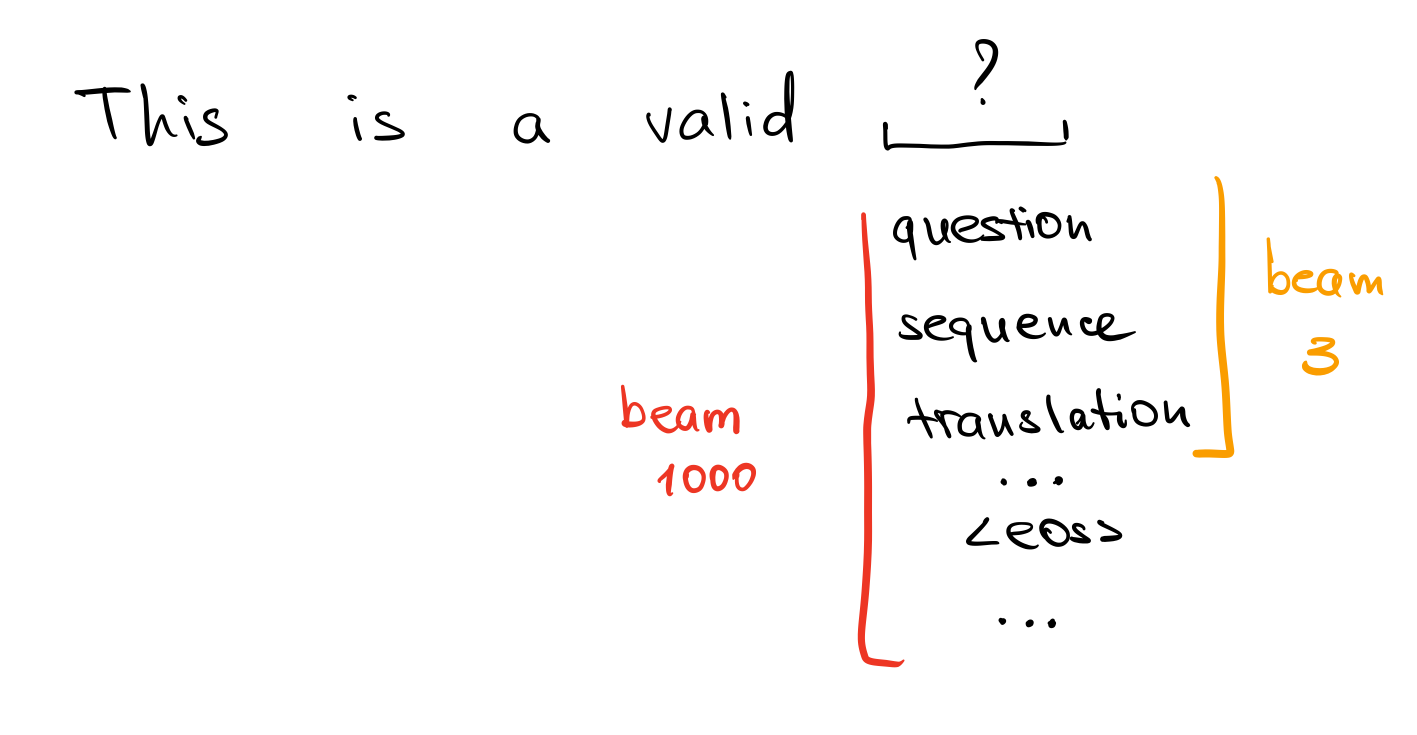

In [61]:
%%capture --no-stdout
%%bash
echo "salut mon nom est max, je suis assistant d'enseignement pour le cours de maîtrise africaine en NLP" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.2 --max-len-b 10 \
    --beam 1000 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁sal ut ▁mon ▁nom ▁est ▁ma x ▁, ▁je ▁suis ▁ass istant ▁d & ap os ; ▁enseign ement ▁pour ▁le ▁cours ▁de ▁ma î tr ise ▁af ric aine ▁en ▁N L P
W-0	1.355	seconds
H-0	-14.9732027053833	▁And ▁my ▁name ▁is ▁a ▁ma x .
D-0	-14.9732027053833	And my name is a max.
P-0	-2.1942 -0.6702 -0.0387 -0.4507 -1.8962 -1.0279 -0.0368 -3.4144 -5.2441


In [62]:
%%capture --no-stdout
%%bash
echo "salut mon nom est max, je suis assistant d'enseignement pour le cours de maîtrise africaine en NLP" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.2 --max-len-b 10 \
    --beam 5 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --unnormalized --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁sal ut ▁mon ▁nom ▁est ▁ma x ▁, ▁je ▁suis ▁ass istant ▁d & ap os ; ▁enseign ement ▁pour ▁le ▁cours ▁de ▁ma î tr ise ▁af ric aine ▁en ▁N L P
W-0	0.286	seconds
H-0	-20.043455123901367	▁And ▁my ▁name ▁is ▁a ▁ma x , ▁and ▁I ' m ▁an ▁ass istant ▁for ▁African ▁master y ▁in ▁N L P .
D-0	-20.043455123901367	And my name is a max, and I'm an assistant for African mastery in NLP.
P-0	-2.1942 -0.6702 -0.0387 -0.4507 -1.8962 -1.0279 -0.0368 -0.8203 -0.4326 -0.2583 -0.4901 -0.0514 -2.6032 -1.3140 -0.1225 -2.5718 -1.5298 -0.2299 -0.9448 -1.2758 -0.0591 -0.0223 -0.1932 -0.7024 -0.1072


### How to spot

* Length Ratio:

$$
\text{LR} = \frac{|\textbf{y}_{\text{ref}}|}{|\textbf{y}_{\text{gen}}|}
$$

Be aware, that LR is token-level, not word-level. Thus, for empty translation the LR denominator equals 1 (empty translation consists of the only token, end-of-sequence).

Corpus-level LR is typically computed as 

$$
\text{LR} = \sum_{i=1}^N\frac{|\textbf{y}^n_{\text{ref}}|}{|\textbf{y}^n_{\text{gen}}|}
$$

In [64]:
def length_ratio(candidate, reference):
    return len(reference.split()) / len(candidate.split())

In [65]:
length_ratio('▁And ▁my ▁name ▁is ▁a ▁ma x . <eos>', 'And my name is a max, and I\'m an assistant for African mastery in NLP. <eos>')

1.7777777777777777

* BLEU

BLEU has a brevity penalty as well! It penalizes the extremely short sequences.

$$
BP=\exp\left(1-\frac{||y_{\text{ref}}||}{||y_{\text{gen}}||}\right)\text{, bit only if } ||y_{\text{ref}}|| < ||y_{\text{gen}}||
$$

$||y_{\text{ref}}||$ and $||y_{\text{gen}}||$ are **word** counts, not token counts.

In [66]:
import sacrebleu

sacrebleu.corpus_bleu(['And my name is a max.'], [['And my name is a max, and I\'m an assistant teacher for the African mastery course in PNL.']])

BLEU = 13.13 100.0/83.3/80.0/75.0 (BP = 0.156 ratio = 0.350 hyp_len = 7 ref_len = 20)

### Tricks

 * Length normalization (penalize the probability for short sequences):

$$
\color{red}{\frac{1}{|\textbf{y}_{gen}|}}\sum_{i=1}^{|\textbf{y}_{gen}|} \log p(y_t | y_{<t})
$$



In [67]:
%%capture --no-stdout
%%bash
echo "salut mon nom est max, je suis assistant d'enseignement pour le cours de maîtrise africaine en PNL" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.2 --max-len-b 10 \
    --beam 1000 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁sal ut ▁mon ▁nom ▁est ▁ma x ▁, ▁je ▁suis ▁ass istant ▁d & ap os ; ▁enseign ement ▁pour ▁le ▁cours ▁de ▁ma î tr ise ▁af ric aine ▁en ▁P N L
W-0	1.364	seconds
H-0	-0.7553730010986328	▁And ▁my ▁name ▁is ▁a ▁ma x , ▁and ▁I ' m ▁an ▁ass istant ▁teacher ▁for ▁the ▁African ▁master y ▁course ▁in ▁P N L .
D-0	-0.7553730010986328	And my name is a max, and I'm an assistant teacher for the African mastery course in PNL.
P-0	-2.1503 -0.6402 -0.0393 -0.4528 -1.8780 -1.0858 -0.0335 -0.8115 -0.4287 -0.2614 -0.4921 -0.0519 -2.6163 -1.2925 -0.1155 -2.9293 -0.7830 -0.9746 -1.1706 -0.3615 -1.0977 -0.2213 -0.3683 -0.0737 -0.0578 -0.5497 -0.1004 -0.1127


* Length penalty when normalization does not help:

$$
\frac{1}{|\textbf{y}_{gen}|^{\color{red}{lp}}}\sum_{i=1}^{|\textbf{y}_{gen}|} \log p(y_t | y_{<t})
$$

When $lp=1.0$ we use standard normalization. For $lp < 1.0$ the model favors shorter translations, for $lp > 1.0$ model prefers longer translations.


In [68]:
%%capture --no-stdout
%%bash
echo "Un transformateur est un modèle d'apprentissage en profondeur qui adopte le mécanisme de l'auto-attention, en pondérant différemment l'importance de chaque partie des données d'entrée. \
      Il est principalement utilisé dans les domaines du traitement du langage naturel (TAL)[1] et de la vision par ordinateur (CV).[2] \
      Comme les réseaux de neurones récurrents (RNN), les transformateurs sont conçus pour traiter des données d'entrée séquentielles, telles que le langage naturel" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.2 --max-len-b 10 \
    --beam 1000 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Un ▁transform ateur ▁est ▁un ▁modèle ▁d & ap os ; ▁app rentissage ▁en ▁profonde ur ▁qui ▁ad op te ▁le ▁mécan isme ▁de ▁l & ap os ; ▁aut o ▁ @ - @ ▁attention ▁, ▁en ▁p ond ér ant ▁diff é re mment ▁l & ap os ; ▁importance ▁de ▁chaque ▁partie ▁des ▁données ▁d & ap os ; ▁ent rée ▁. ▁Il ▁est ▁princip alement ▁utilisé ▁dans ▁les ▁dom aines ▁du ▁traitement ▁du ▁langage ▁nature l ▁( ▁T A L ▁ ) ▁& # 9 1 ; ▁1 ▁& # 9 3 ; ▁et ▁de ▁la ▁vision ▁par ▁ordinateur ▁( ▁C V ▁ ) ▁. ▁& # 9 1 ; ▁2 ▁& # 9 3 ; ▁Comme ▁les ▁rése aux ▁de ▁neur ones ▁réc ur r ents ▁( ▁R N N ▁ ) ▁, ▁les ▁transform ateurs ▁sont ▁con ç us ▁pour ▁traiter ▁des ▁données ▁d & ap os ; ▁ent rée ▁séqu ent ie lles ▁, ▁tell es ▁que ▁le ▁langage ▁nature l
W-0	12.048	seconds
H-0	-1.0138461589813232	▁A ▁transform ative ▁is ▁a ▁model ▁of ▁learning ▁deep ▁inside ▁that ▁adapt s ▁the ▁mechan ism ▁of ▁the ▁self - d ou bt ▁mechan ism , ▁by ▁lay ing ▁in ▁a ▁different ▁way , ▁by ▁different i ating ▁the ▁em ph as is ▁of ▁every ▁part ▁of ▁the ▁input

In [69]:
%%capture --no-stdout
%%bash
echo "Un transformateur est un modèle d'apprentissage en profondeur qui adopte le mécanisme de l'auto-attention, en pondérant différemment l'importance de chaque partie des données d'entrée. \
      Il est principalement utilisé dans les domaines du traitement du langage naturel (TAL)[1] et de la vision par ordinateur (CV).[2] \
      Comme les réseaux de neurones récurrents (RNN), les transformateurs sont conçus pour traiter des données d'entrée séquentielles, telles que le langage naturel" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.2 --max-len-b 10 \
    --beam 1000 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --lenpen 3 --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁Un ▁transform ateur ▁est ▁un ▁modèle ▁d & ap os ; ▁app rentissage ▁en ▁profonde ur ▁qui ▁ad op te ▁le ▁mécan isme ▁de ▁l & ap os ; ▁aut o ▁ @ - @ ▁attention ▁, ▁en ▁p ond ér ant ▁diff é re mment ▁l & ap os ; ▁importance ▁de ▁chaque ▁partie ▁des ▁données ▁d & ap os ; ▁ent rée ▁. ▁Il ▁est ▁princip alement ▁utilisé ▁dans ▁les ▁dom aines ▁du ▁traitement ▁du ▁langage ▁nature l ▁( ▁T A L ▁ ) ▁& # 9 1 ; ▁1 ▁& # 9 3 ; ▁et ▁de ▁la ▁vision ▁par ▁ordinateur ▁( ▁C V ▁ ) ▁. ▁& # 9 1 ; ▁2 ▁& # 9 3 ; ▁Comme ▁les ▁rése aux ▁de ▁neur ones ▁réc ur r ents ▁( ▁R N N ▁ ) ▁, ▁les ▁transform ateurs ▁sont ▁con ç us ▁pour ▁traiter ▁des ▁données ▁d & ap os ; ▁ent rée ▁séqu ent ie lles ▁, ▁tell es ▁que ▁le ▁langage ▁nature l
W-0	12.188	seconds
H-0	-7.098245987435803e-05	▁A ▁transform ative ▁is ▁a ▁model ▁of ▁learning ▁deep ▁inside ▁that ▁adapt s ▁the ▁mechan ism ▁of ▁the ▁self - d ou bt ▁mechan ism , ▁by ▁lay ing ▁in ▁a ▁different ▁way ▁the ▁em ph as is ▁on ▁each ▁part ▁of ▁the ▁input ▁data , ▁and ▁it ' s ▁

### Re-ranking helps to tackle the length degeneracy problems.

* Use a well-trained language model for the target language
* Estimate the probability of every candidate from beam search under the language model
* Re-rank them accodring to the LM's probability
* Well-formed sequences should help to overcome the issue

###Remedy: "Non-terminal oversmoothing loss"

* From "Characterizing and addressing the issue of oversmoothing in neural autoregressive sequence modeling" (Kulikov, Eremeev, Cho 2021) [(Paper)](https://arxiv.org/abs/2112.08914)

* Effective in fixing the beam search curse in the machine translation setting!

## 2.3) Hallucination:

* Due to the inherent uncertainty in natural language:
  * For translation, there are multiple candidate hypotheses that are both well-formed and valid.

* This is where the bias inherent in the data creeps up.
* [ALPS 2022 - Machine Translation and Degeneracies (1)](https://www.youtube.com/watch?v=hoecPa9l2no&t=327s): amazing talk by Prof. Cho that demonstrating and explaining the existence and potential dangers of hallucination in machine translation.
* Analyzing Uncertainty in Neural Machine Translation (Ott et. al. 2018) [(Paper)](https://arxiv.org/abs/1803.00047)

* Even Google Translate struggles from this issue!!!!
   * MUST WATCH! [MT hallucination videos](https://youtube.com/playlist?list=PLdH9u0f1XKW8xMTey65vsmZEH-ib2cFDz)

In [70]:
%%capture --no-stdout
%%bash
echo "mememememememememememe" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.2 --max-len-b 10 \
    --beam 1000 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁mem em em em em em em em em eme
W-0	0.499	seconds
H-0	-1.514109492301941	▁Germany ' s ▁enem y ▁em ph as is .
D-0	-1.514109492301941	Germany's enemy emphasis.
P-0	-5.9265 -0.8541 -0.0824 -4.6888 -0.2200 -0.6711 -3.4153 -0.3387 -0.2244 -0.1297 -0.1041


### How to spot 
  
  * Human Evaluation! It is tricky ([Paper](https://arxiv.org/abs/2005.00661)).

 * Learned metric: BLEURT: BERT trained to match human judgement.

Pre-trained models can be utilized as evaluators too. [Paper](https://arxiv.org/abs/2004.04696).

The final model is the '**reference [sep] candidate**' scorer:

$$
\text{score} = Wv_\text{[CLS]} + b,\\
v_\text{[CLS]} = f_\text{BERT}(ref,cand)
$$


![](https://1.bp.blogspot.com/-RoK03xeSsJ4/XtFYBk7o0ZI/AAAAAAAAGCc/NhvgzVsZfRALLZMmz_XRvxAr9-tcsurGQCLcBGAsYHQ/s400/image4.png)


![](https://1.bp.blogspot.com/-AtLJNnE7Kwc/XtFXyqAPjrI/AAAAAAAAGCU/C-WHyQ-XRxUceITNwpY-TqgHJAfCrxIUwCLcBGAsYHQ/s640/image1.png)

Note: when doing not a translation task, better use the BERTScore version [Paper](https://arxiv.org/abs/1904.09675).

### Tricks (are there any?):

* If we know what to output (entities): Controllable generation! Grid beam search / [DBA](https://aclanthology.org/N18-1119/). 

In [71]:
%%capture --no-stdout
%%bash
echo "incorrectly-formed-sequence" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.2 --max-len-b 10 \
    --beam 1000 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁inc or re ct ly ▁ @ - @ <unk> ▁ @ - @ <unk>
W-0	1.250	seconds
H-0	-1.0155543088912964	▁I ▁don ' t ▁know ▁what ' s ▁wrong ▁with ▁ @ - @ - @ - @ - @ - @ - @ - @ .
D-0	-1.0155543088912964	I don't know what's wrong with @-@-@-@-@-@-@-@.
P-0	-1.6561 -1.8993 -0.1067 -0.0876 -1.2509 -1.6152 -3.2709 -0.0950 -1.8132 -0.0814 -1.9699 -0.1227 -2.1880 -0.2766 -1.0654 -0.3045 -0.9522 -0.3603 -0.7154 -0.4295 -0.6346 -0.4882 -0.9167 -0.5681 -1.2629 -0.7358 -3.5460 -0.0223


In [72]:
%%capture --no-stdout
%%bash
echo -e "incorrectly-formed-sequence\tincorrectly\tformed\tsequence" | fairseq-interactive \
    --path /content/iwslt17fren.pt /content/iwslt-data  \
    --tokenizer moses --bpe sentencepiece --max-len-a 1.2 --max-len-b 10 \
    --beam 1000 --nbest 1 \
    --source-lang fr --target-lang en \
    --remove-bpe --constraints --sentencepiece-model /content/iwslt-data/sentencepiece.bpe.model

S-0	▁inc or re ct ly ▁ @ - @ <unk> ▁ @ - @ <unk>
W-0	25.563	seconds
C-0	▁inc or re ct ly
C-0	▁formed
C-0	▁sequence
H-0	-2.040598154067993	▁I ▁mean , ▁it ' s ▁inc or re ct ly ▁ @ - @ - @ - @ - @ - @ - @ ▁formed . ▁sequence .
D-0	-2.040598154067993	I mean, it's incorrectly @-@-@-@-@-@-@ formed. sequence.
P-0	-1.6561 -3.1994 -0.1526 -3.4081 -0.3667 -0.1034 -7.1732 -0.0190 -0.0316 -0.0014 -0.0579 -0.2736 -0.1398 -1.0432 -0.2758 -1.9315 -0.2759 -1.4401 -0.3219 -0.8928 -0.3760 -0.8968 -0.4262 -1.3673 -0.5280 -16.9617 -0.1014 -16.6280 -1.0584 -0.1098


### Remedies

* Unlikelihood loss [Paper](https://arxiv.org/pdf/1908.04319.pdf). We observe that low-frequency tokens are less likely under the model than high-frequency tokens. Explicitly mimimizing the probability of negative samples on every timestep helps. Stay tuned for the research talk on Friday

In [1]:
# hallucinations e.g what does google translate this sequence:
# Hawaiian: aoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoaoao
# English: you love me you love me you love me you love me you love me.